In [2]:
import pandas as pd
import numpy as np
from numpy import argmax
from numpy import sqrt
import math
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score
from sklearn.utils import resample
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from statistics import median
from matplotlib import pyplot
import pickle
import csv
import warnings
warnings.filterwarnings("ignore")

In [4]:
def output_values(Y_data):
    Y_t = []
    for e in Y_data:
        if e == 'passed':
            Y_t.append(1)
        else:
            Y_t.append(0) 
    return Y_t

In [5]:
def get_pass_streak(y_project):
    p = y_project[0]
    pass_streak = [y_project[0]]
    for i in range(1, len(y_project)):
        pass_streak.append(p)
        if y_project[i] == 1:
            p += 1
        else:
            p = 0
    return pass_streak

In [6]:
def get_first_failures(df):
    
    results = df['tr_status'].tolist()
    length = len(results)
    verdict = ['keep']
    prev = results[0]
    
    for i in range(1, length):
        if results[i] == 0:
            if prev == 0:
                verdict.append('discard')
                #print(i+1)
            else:
                verdict.append('keep')
        else:
            verdict.append('keep')
        prev = results[i]
    
    df['verdict'] = verdict
    df = df[ df['verdict'] == 'keep' ]
    df.drop('verdict', inplace=True, axis=1)
    return df

In [244]:
cloud_controller = pd.read_csv('metrics_data/cloud_controller_ng_metrics.csv')

with open('../cloud_controller_ng_indexes.pkl', 'rb') as load_file:
    cloud_train_build_ids = pickle.load(load_file)
    cloud_test_build_ids = pickle.load(load_file)

cloud_controller = cloud_controller [ cloud_controller['tr_build_id'].isin(cloud_train_build_ids)]
cloud_controller = cloud_controller [ cloud_controller['developer_experience'] >= 0]

cloud_train_build_ids = cloud_controller['tr_build_id'].tolist()
res_cloud_controller = pd.read_csv('../data/cloud_controller_ng.csv', usecols = ['tr_build_id', 'tr_status'])
y_cloud_controller = res_cloud_controller [ res_cloud_controller['tr_build_id'].isin(cloud_train_build_ids)]['tr_status'].tolist()
y_cloud_controller = output_values(y_cloud_controller)
cloud_controller['tr_status'] = y_cloud_controller
# cloud_controller = get_first_failures(cloud_controller)
# cloud_train_build_ids = cloud_controller['tr_build_id'].tolist()
# y_cloud_controller = cloud_controller['tr_status'].tolist()

In [245]:
geoserver = pd.read_csv('metrics_data/geoserver_metrics.csv')

with open('../geoserver_indexes.pkl', 'rb') as load_file:
    geoserver_train_build_ids = pickle.load(load_file)
    geoserver_test_build_ids = pickle.load(load_file)

geoserver = geoserver [ geoserver['tr_build_id'].isin(geoserver_train_build_ids)]
geoserver = geoserver [ geoserver['developer_experience'] >= 0]

geoserver_train_build_ids = geoserver['tr_build_id'].tolist()
res_geoserver = pd.read_csv('../data/geoserver.csv', usecols = ['tr_build_id', 'tr_status'])
y_geoserver = res_geoserver [ res_geoserver['tr_build_id'].isin(geoserver_train_build_ids)]['tr_status'].tolist()
y_geoserver = output_values(y_geoserver)
geoserver['tr_status'] = y_geoserver

# geoserver = get_first_failures(geoserver)
# geoserver_train_build_ids = geoserver['tr_build_id'].tolist()
# y_geoserver = geoserver['tr_status'].tolist()

In [246]:
gradle = pd.read_csv('metrics_data/gradle_metrics copy 2.csv')

with open('../gradle_indexes.pkl', 'rb') as load_file:
    gradle_train_build_ids = pickle.load(load_file)
    gradle_test_build_ids = pickle.load(load_file)

gradle = gradle [ gradle['tr_build_id'].isin(gradle_train_build_ids)]
gradle = gradle [ gradle['developer_experience'] >= 0]

gradle_train_build_ids = gradle['tr_build_id'].tolist()

res_gradle = pd.read_csv('../data/gradle.csv', usecols = ['tr_build_id', 'tr_status'])
y_gradle = res_gradle [ res_gradle['tr_build_id'].isin(gradle_train_build_ids)]['tr_status'].tolist()
y_gradle = output_values(y_gradle)
gradle['tr_status'] = y_gradle

# gradle = get_first_failures(gradle)
# gradle_train_build_ids = gradle['tr_build_id'].tolist()
# y_gradle = gradle['tr_status'].tolist()

In [247]:
projects = [gradle, cloud_controller, geoserver]

In [248]:
gradle.drop('num_commits', inplace=True, axis=1)
gradle.drop('reviewer_experience', inplace=True, axis=1)
gradle.drop('num_of_reviewers', inplace=True, axis=1)

cloud_controller.drop('num_commits', inplace=True, axis=1)
cloud_controller.drop('reviewer_experience', inplace=True, axis=1)
cloud_controller.drop('num_of_reviewers', inplace=True, axis=1)

geoserver.drop('num_commits', inplace=True, axis=1)
geoserver.drop('reviewer_experience', inplace=True, axis=1)
geoserver.drop('num_of_reviewers', inplace=True, axis=1)

In [249]:
gradle['num_of_passes'] = get_pass_streak(y_gradle)
cloud_controller['num_of_passes'] = get_pass_streak(y_cloud_controller)
geoserver['num_of_passes'] = get_pass_streak(y_geoserver)

In [21]:
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
max_depth = [int(x) for x in np.linspace(10, 110, num = 5)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]

In [22]:
param_grid = {'n_estimators': n_estimators,
               'max_depth': max_depth
             }

In [23]:
forest = RandomForestClassifier()
grid_search = GridSearchCV(estimator = forest, param_grid = param_grid, 
                      cv = 3, n_jobs = -1, verbose = 2)

In [253]:
#estimating for geoserver

X_train = geoserver
y_train = y_geoserver

# geoserver = pd.read_csv('metrics_data/geoserver_metrics.csv')
# X_test = np.array(geoserver [ geoserver['tr_build_id'].isin(geoserver_test_build_ids)])
# geoserver_train_build_ids = geoserver['tr_build_id'].tolist()
# res_geoserver = pd.read_csv('../data/geoserver.csv', usecols = ['tr_build_id', 'tr_status'])
# y_geoserver = res_geoserver [ res_geoserver['tr_build_id'].isin(geoserver_test_build_ids)]['tr_status'].tolist()
# y_test = np.array(output_values(y_geoserver))

In [254]:
print(len(X_train))
print(len(y_train))

1924
1924


In [255]:
sample_size = int(len(geoserver)*0.7)

best_precision = 0
best_recall = 0
best_accuracy = 0
best_threshold = 0
best_auc = 0

best_precision_sample = np.array([0])
best_precision_sample_result = np.array([0])
best_recall_sample = np.array([0])
best_recall_sample_result = np.array([0])
best_accuracy_sample = np.array([0])
best_accuracy_sample_result = np.array([0])
best_auc_sample = np.array([0])
best_auc_sample_result = np.array([0])


best_precision_estimator = 0
best_recall_estimator = 0
best_accuracy_estimator = 0
best_auc_estimator = 0

count = 0

#bootstrapping 100 times
for i in range(20):
    
    file_name = 'rq2_geoserver_model_' + str(i+1) + '_model.pkl'
    pickle_dump_objects = []
    
    #getting required sample from training data
    sample_train = resample(X_train, replace=True, n_samples=sample_size)
    #sample_train_result = np.array(sample_train['tr_status'])
    sample_train_result = sample_train['tr_status']
    
    #getting the build_ids that are used in training 
    build_ids = sample_train['tr_build_id'].tolist()
    
    #extracting remaining build id's to use for testing
    sample_test = X_train [~X_train['tr_build_id'].isin(build_ids)]
    #sample_test_result = np.array(sample_test['tr_status'])
    sample_test_result = sample_test['tr_status']

    
    print(len(sample_train))
    print(len(sample_test))
    
    #dropping result column and build ids column
    sample_train.drop('tr_status', inplace=True, axis=1)
    sample_train.drop('tr_build_id', inplace=True, axis=1)
    sample_test.drop('tr_status', inplace=True, axis=1)
    sample_test.drop('tr_build_id', inplace=True, axis=1)
    
    
    pickle_dump_objects.append(sample_train)
    pickle_dump_objects.append(sample_train_result)
    pickle_dump_objects.append(sample_test)
    pickle_dump_objects.append(sample_test_result)
    
    #training
    grid_search.fit(sample_train, sample_train_result)
    
    #predicting with sample_test
    sample_pred_result = grid_search.predict_proba(sample_test)
    
    pickle_dump_objects.append(grid_search.best_estimator_)
    pickle_dump_objects.append(sample_pred_result)
    
    
    #getting the best threshold
    pred_vals = sample_pred_result[:, 1]
    fpr, tpr, thresholds = roc_curve(sample_test_result, pred_vals)
    gmeans = sqrt(tpr * (1-fpr))
    ix = argmax(gmeans)
    best_threshold = thresholds[ix]
    
    final_pred_result = []
    #threshold setting
    for i in range(len(pred_vals)):
        if pred_vals[i] > best_threshold:
            final_pred_result.append(1)
        else:
            final_pred_result.append(0)
    
    if count < 3:
        print(list(sample_test_result))
        print(final_pred_result)
        count += 1
    
    pickle_dump_objects.append(final_pred_result)
    
    with open(file_name, 'wb') as dump_file:
        for obj in pickle_dump_objects:
            pickle.dump(obj, dump_file)
    
    accuracy = accuracy_score(sample_test_result, final_pred_result)
    precision = precision_score(sample_test_result, final_pred_result)
    recall = recall_score(sample_test_result, final_pred_result)
    confusion = confusion_matrix(sample_test_result, final_pred_result)
    auc_score = roc_auc_score(sample_test_result, final_pred_result)
    
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_accuracy_sample = sample_train
        best_accuracy_sample_result = sample_train_result
        best_accuracy_estimator = grid_search.best_estimator_
        
    if precision > best_precision:
        best_precision = precision
        best_precision_sample = sample_train
        best_precision_sample_result = sample_train_result
        best_precision_estimator = grid_search.best_estimator_
        best_threshold = thresholds[ix]
        
    if recall > best_recall:
        best_recall = recall
        best_recall_sample = sample_train
        best_recall_sample_result = sample_train_result
        best_recall_estimator = grid_search.best_estimator_
        
    if auc_score > best_auc:
        best_auc = auc_score
        best_auc_sample = sample_train
        best_auc_sample_result = sample_train_result
        best_auc_estimator = grid_search.best_estimator_
    
    print(precision, recall, accuracy, auc_score)
    print(confusion)
        
    

1346
954
Fitting 3 folds for each of 60 candidates, totalling 180 fits
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 

0.7353629976580797 0.6582809224318659 0.7148760330578512 0.71406917812021
[[378 113]
 [163 314]]
1346
964
Fitting 3 folds for each of 60 candidates, totalling 180 fits
0.7166276346604216 0.652452025586354 0.7053941908713693 0.7040037905709547
[[374 121]
 [163 306]]
1346
943
Fitting 3 folds for each of 60 candidates, totalling 180 fits
0.6918918918918919 0.810126582278481 0.7232237539766702 0.7227605192842298
[[298 171]
 [ 90 384]]
[CV] END .....................max_depth=10, n_estimators=600; total time=   2.5s
[CV] END ....................max_depth=10, n_estimators=1200; total time=   5.0s
[CV] END ....................max_depth=10, n_estimators=1600; total time=   6.3s
[CV] END .....................max_depth=35, n_estimators=200; total time=   0.9s
[CV] END .....................max_depth=35, n_estimators=400; total time=   1.7s
[CV] END .....................max_depth=35, n_estimators=600; total time=   2.6s
[CV] END ....................max_depth=35, n_estimators=1200; total time=   5.4

[CV] END .....................max_depth=10, n_estimators=600; total time=   2.5s
[CV] END ....................max_depth=10, n_estimators=1000; total time=   4.2s
[CV] END ....................max_depth=10, n_estimators=1600; total time=   6.3s
[CV] END .....................max_depth=35, n_estimators=200; total time=   0.9s
[CV] END .....................max_depth=35, n_estimators=200; total time=   0.9s
[CV] END .....................max_depth=35, n_estimators=400; total time=   1.7s
[CV] END .....................max_depth=35, n_estimators=600; total time=   2.6s
[CV] END ....................max_depth=35, n_estimators=1000; total time=   4.4s
[CV] END ....................max_depth=35, n_estimators=1600; total time=   7.0s
[CV] END .....................max_depth=60, n_estimators=200; total time=   0.9s
[CV] END .....................max_depth=60, n_estimators=200; total time=   0.9s
[CV] END .....................max_depth=60, n_estimators=400; total time=   1.7s
[CV] END ...................

[CV] END .....................max_depth=10, n_estimators=400; total time=   1.6s
[CV] END .....................max_depth=10, n_estimators=800; total time=   3.3s
[CV] END ....................max_depth=10, n_estimators=1400; total time=   5.6s
[CV] END ....................max_depth=10, n_estimators=2000; total time=   7.9s
[CV] END .....................max_depth=35, n_estimators=800; total time=   3.6s
[CV] END ....................max_depth=35, n_estimators=1400; total time=   6.1s
[CV] END ....................max_depth=35, n_estimators=2000; total time=   8.7s
[CV] END ....................max_depth=60, n_estimators=1000; total time=   4.4s
[CV] END ....................max_depth=60, n_estimators=1400; total time=   4.1s
[CV] END ....................max_depth=60, n_estimators=2000; total time=   4.8s
[CV] END ....................max_depth=85, n_estimators=1200; total time=   2.9s
[CV] END ....................max_depth=85, n_estimators=1600; total time=   3.8s
[CV] END ...................

[CV] END .....................max_depth=10, n_estimators=400; total time=   1.6s
[CV] END ....................max_depth=10, n_estimators=1000; total time=   4.2s
[CV] END ....................max_depth=10, n_estimators=1400; total time=   5.5s
[CV] END ....................max_depth=10, n_estimators=2000; total time=   7.9s
[CV] END ....................max_depth=35, n_estimators=1000; total time=   4.5s
[CV] END ....................max_depth=35, n_estimators=1600; total time=   6.8s
[CV] END ....................max_depth=35, n_estimators=2000; total time=   8.8s
[CV] END ....................max_depth=60, n_estimators=1400; total time=   5.1s
[CV] END ....................max_depth=60, n_estimators=1800; total time=   4.2s
[CV] END .....................max_depth=85, n_estimators=800; total time=   2.1s
[CV] END ....................max_depth=85, n_estimators=1200; total time=   3.0s
[CV] END ....................max_depth=85, n_estimators=1800; total time=   4.3s
[CV] END ...................

[CV] END .....................max_depth=10, n_estimators=200; total time=   0.8s
[CV] END .....................max_depth=10, n_estimators=600; total time=   2.5s
[CV] END ....................max_depth=10, n_estimators=1200; total time=   5.0s
[CV] END ....................max_depth=10, n_estimators=1800; total time=   7.3s
[CV] END .....................max_depth=35, n_estimators=400; total time=   1.7s
[CV] END .....................max_depth=35, n_estimators=800; total time=   3.6s
[CV] END ....................max_depth=35, n_estimators=1200; total time=   5.3s
[CV] END ....................max_depth=35, n_estimators=1800; total time=   7.8s
[CV] END .....................max_depth=60, n_estimators=600; total time=   2.7s
[CV] END .....................max_depth=60, n_estimators=800; total time=   3.6s
[CV] END ....................max_depth=60, n_estimators=1400; total time=   4.8s
[CV] END ....................max_depth=60, n_estimators=2000; total time=   4.6s
[CV] END ...................

[CV] END .....................max_depth=10, n_estimators=200; total time=   0.8s
[CV] END .....................max_depth=10, n_estimators=800; total time=   3.3s
[CV] END ....................max_depth=10, n_estimators=1400; total time=   5.7s
[CV] END ....................max_depth=10, n_estimators=1800; total time=   7.1s
[CV] END .....................max_depth=35, n_estimators=800; total time=   3.6s
[CV] END ....................max_depth=35, n_estimators=1400; total time=   6.2s
[CV] END ....................max_depth=35, n_estimators=1800; total time=   7.9s
[CV] END .....................max_depth=60, n_estimators=800; total time=   3.6s
[CV] END ....................max_depth=60, n_estimators=1200; total time=   4.9s
[CV] END ....................max_depth=60, n_estimators=1800; total time=   4.4s
[CV] END .....................max_depth=85, n_estimators=400; total time=   0.9s
[CV] END .....................max_depth=85, n_estimators=800; total time=   2.1s
[CV] END ...................

[CV] END .....................max_depth=10, n_estimators=200; total time=   0.8s
[CV] END .....................max_depth=10, n_estimators=800; total time=   3.3s
[CV] END ....................max_depth=10, n_estimators=1200; total time=   4.9s
[CV] END ....................max_depth=10, n_estimators=1800; total time=   7.1s
[CV] END .....................max_depth=35, n_estimators=600; total time=   2.5s
[CV] END ....................max_depth=35, n_estimators=1000; total time=   4.5s
[CV] END ....................max_depth=35, n_estimators=1400; total time=   6.2s
[CV] END ....................max_depth=35, n_estimators=2000; total time=   8.7s
[CV] END ....................max_depth=60, n_estimators=1200; total time=   5.0s
[CV] END ....................max_depth=60, n_estimators=1600; total time=   3.9s
[CV] END .....................max_depth=85, n_estimators=400; total time=   0.9s
[CV] END .....................max_depth=85, n_estimators=600; total time=   1.4s
[CV] END ...................

In [256]:
with open('dump_geoserver_rq2_ml_streak_chron_model', 'wb') as dump_file:
    pickle.dump(best_precision_estimator, dump_file)
    pickle.dump(best_recall_estimator, dump_file)
    pickle.dump(best_accuracy_estimator, dump_file)
    pickle.dump(best_auc_estimator, dump_file)
    pickle.dump(best_auc_sample_result, dump_file)
    pickle.dump(best_auc_sample, dump_file)
    pickle.dump(best_auc, dump_file)
    pickle.dump(best_precision, dump_file)
    pickle.dump(best_precision_sample, dump_file)
    pickle.dump(best_precision_sample_result, dump_file)
    pickle.dump(best_accuracy, dump_file)
    pickle.dump(best_accuracy_sample, dump_file)
    pickle.dump(best_accuracy_sample_result, dump_file)
    pickle.dump(best_recall, dump_file)
    pickle.dump(best_recall_sample, dump_file)
    pickle.dump(best_recall_sample_result, dump_file)

In [257]:
geoserver = pd.read_csv('metrics_data/geoserver_metrics.csv')
geoserver.drop('num_commits', inplace=True, axis=1)
geoserver.drop('reviewer_experience', inplace=True, axis=1)
geoserver.drop('num_of_reviewers', inplace=True, axis=1)

X_test = geoserver [ geoserver['tr_build_id'].isin(geoserver_test_build_ids)]
X_test = X_test [ X_test['developer_experience'] >= 0]
geoserver_test_build_ids = X_test['tr_build_id'].tolist()

X_test.drop('tr_build_id', inplace=True, axis=1)

res_geoserver = pd.read_csv('../data/geoserver.csv', usecols = ['tr_build_id', 'tr_status'])
y_geoserver = res_geoserver [ res_geoserver['tr_build_id'].isin(geoserver_test_build_ids)]['tr_status'].tolist()

y_test = output_values(y_geoserver)
#X_test['num_of_passes'] = get_pass_streak(y_test)
print(X_test)

      patch_size  num_of_comments  test_file_changes  files_added  \
1712           0                0                  0            0   
1713          18                0                  0            0   
1714           4                0                  0            0   
1715          10                0                 20            0   
1716           0                0                  0            0   
...          ...              ...                ...          ...   
1860           3                0                 53            1   
1861           0                0                  0            0   
1862           7                0                 34            0   
1863           0                0                  0            0   
1864         898                0                 54            3   

      files_deleted  frequency_file_change  developer_experience  
1712              0                    233                  1266  
1713              0                  

In [258]:
print(X_train.iloc[1711])

tr_build_id              118148895
patch_size                       0
num_of_comments                  0
test_file_changes                0
files_added                      0
files_deleted                    0
frequency_file_change          428
developer_experience          1333
tr_status                        0
num_of_passes                    0
Name: 1875, dtype: int64


In [259]:
temp_x = geoserver [ geoserver['tr_build_id'].isin(geoserver_test_build_ids)]
temp_x = temp_x [ temp_x['developer_experience'] >= 0]
geoserver_test_build_ids = temp_x['tr_build_id'].tolist()


In [260]:
# estimating the most precise estimator for testing geoserver



estimator = best_auc_estimator
estimator.fit(best_auc_sample, best_auc_sample_result)

pred_results = []
queue = 0
for i in range(len(X_test)):
    val = X_test.iloc[i].tolist()
    val.append(queue)
    res = estimator.predict_proba([np.array(val)])
    if res[0][1] > best_threshold:
        pred_results.append(1)
        queue += 1
    else:
        pred_results.append(0)
        queue = 0

final_pred_result = pred_results

print(best_threshold)
print(roc_auc_score(y_test, final_pred_result))
print(precision_score(y_test, final_pred_result))
print(accuracy_score(y_test, final_pred_result))
print(f1_score(y_test, final_pred_result))

compute_performance('geoserver', geoserver_test_build_ids, y_test, final_pred_result)

X_test['num_of_passes'] = get_pass_streak(y_test)
print(X_test)
pred_results = estimator.predict_proba(X_test)

pred_vals = pred_results[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, pred_vals)
gmeans = sqrt(tpr * (1-fpr))
ix = argmax(gmeans)
bt = thresholds[ix]

final_pred_result = []
#threshold setting
for i in range(len(pred_vals)):
    if pred_vals[i] > bt:
        final_pred_result.append(1)
    else:
        final_pred_result.append(0)


print(best_threshold)
print(roc_auc_score(y_test, final_pred_result))
print(precision_score(y_test, final_pred_result))
print(accuracy_score(y_test, final_pred_result))
print(f1_score(y_test, final_pred_result))

compute_performance('geoserver', geoserver_test_build_ids, y_test, final_pred_result)

0.41
0.5079869460666437
0.54
0.5424836601307189
0.6982758620689655
The performance of the model is as follows:
	 Time saved : 2.8051597190896294
	 Builds saved : 98.03921568627452
	 Builds required : 2.6143790849673203
	 Failed Builds Identified : 2.816901408450704
	 Median Delay Induced : 62.5 builds
	 Total Delay Induced: 125 builds
	 Total number of builds: 153
      patch_size  num_of_comments  test_file_changes  files_added  \
1712           0                0                  0            0   
1713          18                0                  0            0   
1714           4                0                  0            0   
1715          10                0                 20            0   
1716           0                0                  0            0   
...          ...              ...                ...          ...   
1860           3                0                 53            1   
1861           0                0                  0            0   
1862        

In [131]:
print(final_pred_result)

[1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [132]:
print(y_test)

[1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [133]:
total_builds = 0
build_time = 0

cur_batch = []
batch_results = []
max_batch_size = 4

num = 0

actual_results = y_test

for i in range(len(final_pred_result)):
    
    if final_pred_result[i] == 0:
        if len(cur_batch) < max_batch_size:
            cur_batch.append(actual_results[i])
            
        if len(cur_batch) == max_batch_size:
            num += 1
            if 0 in cur_batch:
                num += 4
            
            cur_batch.clear()
            batch_results.clear()

if len(cur_batch) != 0:
    num += 1
    if 0 in batch_results:
        num += len(cur_batch)

print(num)
print(len(final_pred_result))

73
153


# Predictor for Gradle

In [262]:
X_train = gradle
y_train = y_gradle

In [263]:
sample_size = int(len(gradle)*0.7)

best_precision = 0
best_recall = 0
best_accuracy = 0
best_threshold = 0
best_auc = 0

best_precision_sample = np.array([0])
best_precision_sample_result = np.array([0])
best_recall_sample = np.array([0])
best_recall_sample_result = np.array([0])
best_accuracy_sample = np.array([0])
best_accuracy_sample_result = np.array([0])
best_auc_sample = np.array([0])
best_auc_sample_result = np.array([0])


best_precision_estimator = 0
best_recall_estimator = 0
best_accuracy_estimator = 0
best_auc_estimator = 0

count = 0

#bootstrapping 100 times
for i in range(20):
    
    file_name = 'rq2_gradle_model_' + str(i+1) + '_model.pkl'
    pickle_dump_objects = []
    
    #getting required sample from training data
    sample_train = resample(X_train, replace=True, n_samples=sample_size)
    #sample_train_result = np.array(sample_train['tr_status'])
    sample_train_result = sample_train['tr_status']
    
    #getting the build_ids that are used in training 
    build_ids = sample_train['tr_build_id'].tolist()
    
    #extracting remaining build id's to use for testing
    sample_test = X_train [~X_train['tr_build_id'].isin(build_ids)]
    #sample_test_result = np.array(sample_test['tr_status'])
    sample_test_result = sample_test['tr_status']

    
    print(len(sample_train))
    print(len(sample_test))
    
    #dropping result column and build ids column
    sample_train.drop('tr_status', inplace=True, axis=1)
    sample_train.drop('tr_build_id', inplace=True, axis=1)
    sample_test.drop('tr_status', inplace=True, axis=1)
    sample_test.drop('tr_build_id', inplace=True, axis=1)
    
    
    pickle_dump_objects.append(sample_train)
    pickle_dump_objects.append(sample_train_result)
    pickle_dump_objects.append(sample_test)
    pickle_dump_objects.append(sample_test_result)
    
    #training
    grid_search.fit(sample_train, sample_train_result)
    
    #predicting with sample_test
    sample_pred_result = grid_search.predict_proba(sample_test)
    
    pickle_dump_objects.append(grid_search.best_estimator_)
    pickle_dump_objects.append(sample_pred_result)
    
    
    #getting the best threshold
    pred_vals = sample_pred_result[:, 1]
    fpr, tpr, thresholds = roc_curve(sample_test_result, pred_vals)
    gmeans = sqrt(tpr * (1-fpr))
    ix = argmax(gmeans)
    best_threshold = thresholds[ix]
    
    final_pred_result = []
    #threshold setting
    for i in range(len(pred_vals)):
        if pred_vals[i] > best_threshold:
            final_pred_result.append(1)
        else:
            final_pred_result.append(0)
    
    if count < 3:
        print(list(sample_test_result))
        print(final_pred_result)
        count += 1
    
    pickle_dump_objects.append(final_pred_result)
    
    with open(file_name, 'wb') as dump_file:
        for obj in pickle_dump_objects:
            pickle.dump(obj, dump_file)
    
    accuracy = accuracy_score(sample_test_result, final_pred_result)
    precision = precision_score(sample_test_result, final_pred_result)
    recall = recall_score(sample_test_result, final_pred_result)
    confusion = confusion_matrix(sample_test_result, final_pred_result)
    auc_score = roc_auc_score(sample_test_result, final_pred_result)
    
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_accuracy_sample = sample_train
        best_accuracy_sample_result = sample_train_result
        best_accuracy_estimator = grid_search.best_estimator_
        
    if precision > best_precision:
        best_precision = precision
        best_precision_sample = sample_train
        best_precision_sample_result = sample_train_result
        best_precision_estimator = grid_search.best_estimator_
        best_threshold = thresholds[ix]
        
    if recall > best_recall:
        best_recall = recall
        best_recall_sample = sample_train
        best_recall_sample_result = sample_train_result
        best_recall_estimator = grid_search.best_estimator_
        
    if auc_score > best_auc:
        best_auc = auc_score
        best_auc_sample = sample_train
        best_auc_sample_result = sample_train_result
        best_auc_estimator = grid_search.best_estimator_
        
    print(i)
    print(precision, recall, accuracy, auc_score)
    print(confusion)
        
    

704
495
Fitting 3 folds for each of 60 candidates, totalling 180 fits
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

489
0.971875 0.6588983050847458 0.6530612244897959 0.5794491525423728
[[  9   9]
 [161 311]]
704
497
Fitting 3 folds for each of 60 candidates, totalling 180 fits
496
0.9859154929577465 0.5857740585774058 0.5935613682092555 0.6876238713939661
[[ 15   4]
 [198 280]]
704
503
Fitting 3 folds for each of 60 candidates, totalling 180 fits
502
0.9826589595375722 0.7010309278350515 0.6998011928429424 0.6838487972508592
[[ 12   6]
 [145 340]]
704
497
Fitting 3 folds for each of 60 candidates, totalling 180 fits
496
0.978891820580475 0.7745302713987474 0.7665995975855131 0.6650429134771515
[[ 10   8]
 [108 371]]
704
508
Fitting 3 folds for each of 60 candidates, totalling 180 fits
507
0.9811320754716981 0.7443762781186094 0.7401574803149606 0.6879776127435151
[[ 12   7]
 [125 364]]
704
504
Fitting 3 folds for each of 60 candidates, totalling 180 fits
503
0.9682539682539683 0.7593360995850622 0.746031746031746 0.6069407770652584
[[ 10  12]
 [116 366]]
704
503
Fitting 3 folds for each of 60 candi

In [264]:
with open('dump_gradle_rq2_ml_streak_chron_model', 'wb') as dump_file:
    pickle.dump(best_precision_estimator, dump_file)
    pickle.dump(best_recall_estimator, dump_file)
    pickle.dump(best_accuracy_estimator, dump_file)
    pickle.dump(best_auc_estimator, dump_file)
    pickle.dump(best_auc_sample_result, dump_file)
    pickle.dump(best_auc_sample, dump_file)
    pickle.dump(best_auc, dump_file)
    pickle.dump(best_precision, dump_file)
    pickle.dump(best_precision_sample, dump_file)
    pickle.dump(best_precision_sample_result, dump_file)
    pickle.dump(best_accuracy, dump_file)
    pickle.dump(best_accuracy_sample, dump_file)
    pickle.dump(best_accuracy_sample_result, dump_file)
    pickle.dump(best_recall, dump_file)
    pickle.dump(best_recall_sample, dump_file)
    pickle.dump(best_recall_sample_result, dump_file)

In [265]:
gradle = pd.read_csv('metrics_data/gradle_metrics copy 2.csv')
gradle.drop('num_commits', inplace=True, axis=1)
gradle.drop('reviewer_experience', inplace=True, axis=1)
gradle.drop('num_of_reviewers', inplace=True, axis=1)
#gradle.drop('developer_experience', inplace=True, axis=1)

X_test = gradle [ gradle['tr_build_id'].isin(gradle_test_build_ids)]
#print(X_test)
gradle_test_build_ids = X_test['tr_build_id'].tolist()

X_test.drop('tr_build_id', inplace=True, axis=1)

res_gradle = pd.read_csv('../data/gradle.csv', usecols = ['tr_build_id', 'tr_status'])
y_gradle = res_gradle [ res_gradle['tr_build_id'].isin(gradle_test_build_ids)]['tr_status'].tolist()

y_test = output_values(y_gradle)
#X_test['num_of_passes'] = get_pass_streak(y_test)
print(X_test)

      patch_size  num_of_comments  test_file_changes  files_added  \
1008         212                0                  0            0   
1009          37                0                  0            0   
1010           6                0                  0            0   
1011           0                0                  0            0   
1012         315                0                  4            0   
...          ...              ...                ...          ...   
1135         139                0                 13            1   
1136           6                0                  0            0   
1137         168                0                  0            1   
1138         122                0                  0            0   
1139         144                0                  0            0   

      files_deleted  frequency_file_change  developer_experience  
1008              0                     83                     0  
1009              0                  

In [266]:
temp_x = gradle [ gradle['tr_build_id'].isin(gradle_test_build_ids)]
temp_x = temp_x [ temp_x['developer_experience'] >= 0]
gradle_test_build_ids = temp_x['tr_build_id'].tolist()
#compute_performance('gradle', gradle_test_build_ids, y_test, final_pred_result)

In [267]:
# estimating the most precise estimator for testing geoserver

print(y_test)

estimator = best_auc_estimator
estimator.fit(best_auc_sample, best_auc_sample_result)

pred_results = []
queue = 1
for i in range(len(X_test)):
    val = X_test.iloc[i].tolist()
    val.append(queue)
    res = estimator.predict_proba([np.array(val)])
    if res[0][1] > best_threshold:
        pred_results.append(1)
        queue += 1
    else:
        pred_results.append(0)
        queue = 0

final_pred_result = pred_results
print(final_pred_result)

print(best_threshold)
print(roc_auc_score(y_test, final_pred_result))
print(precision_score(y_test, final_pred_result))
print(accuracy_score(y_test, final_pred_result))
print(f1_score(y_test, final_pred_result))

compute_performance('gradle', gradle_test_build_ids, y_test, final_pred_result)

X_test['num_of_passes'] = get_pass_streak(y_test)
print(X_test)
pred_results = estimator.predict_proba(X_test)

pred_vals = pred_results[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, pred_vals)
gmeans = sqrt(tpr * (1-fpr))
ix = argmax(gmeans)
bt = thresholds[ix]

final_pred_result = []
#threshold setting
for i in range(len(pred_vals)):
    if pred_vals[i] > bt:
        final_pred_result.append(1)
    else:
        final_pred_result.append(0)

print(final_pred_result)
print(bt)
print(roc_auc_score(y_test, final_pred_result))
print(precision_score(y_test, final_pred_result))
print(accuracy_score(y_test, final_pred_result))
print(f1_score(y_test, final_pred_result))

compute_performance('gradle', gradle_test_build_ids, y_test, final_pred_result)

[1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
0.9599064572622028
0.516
1.0
0.08333333333333333
0.06201550387596899
The performance of the model is as follows:
	 Time saved : 444.3483202096694
	 Builds saved : 3.0303030303030303
	 Builds required : 477.

In [268]:
grid_search.best_estimator_

RandomForestClassifier(max_depth=10, n_estimators=400)

[CV] END .....................max_depth=10, n_estimators=600; total time=   1.3s
[CV] END ....................max_depth=10, n_estimators=1200; total time=   2.7s
[CV] END ....................max_depth=10, n_estimators=1800; total time=   3.9s
[CV] END .....................max_depth=35, n_estimators=400; total time=   0.9s
[CV] END .....................max_depth=35, n_estimators=800; total time=   1.7s
[CV] END ....................max_depth=35, n_estimators=1200; total time=   2.6s
[CV] END ....................max_depth=35, n_estimators=1800; total time=   3.8s
[CV] END .....................max_depth=60, n_estimators=400; total time=   0.6s
[CV] END .....................max_depth=60, n_estimators=800; total time=   1.2s
[CV] END ....................max_depth=60, n_estimators=1200; total time=   2.2s
[CV] END ....................max_depth=60, n_estimators=1800; total time=   3.9s
[CV] END .....................max_depth=85, n_estimators=600; total time=   1.4s
[CV] END ...................

[CV] END .....................max_depth=10, n_estimators=400; total time=   0.9s
[CV] END ....................max_depth=10, n_estimators=1000; total time=   2.2s
[CV] END ....................max_depth=10, n_estimators=1600; total time=   3.4s
[CV] END ....................max_depth=10, n_estimators=2000; total time=   4.5s
[CV] END ....................max_depth=35, n_estimators=1200; total time=   2.6s
[CV] END ....................max_depth=35, n_estimators=1800; total time=   3.7s
[CV] END .....................max_depth=60, n_estimators=600; total time=   0.9s
[CV] END .....................max_depth=60, n_estimators=800; total time=   1.0s
[CV] END ....................max_depth=60, n_estimators=1400; total time=   2.9s
[CV] END ....................max_depth=60, n_estimators=2000; total time=   4.2s
[CV] END ....................max_depth=85, n_estimators=1000; total time=   2.1s
[CV] END ....................max_depth=85, n_estimators=1400; total time=   2.9s
[CV] END ...................

[CV] END .....................max_depth=10, n_estimators=400; total time=   0.9s
[CV] END .....................max_depth=10, n_estimators=800; total time=   1.8s
[CV] END ....................max_depth=10, n_estimators=1400; total time=   3.0s
[CV] END ....................max_depth=10, n_estimators=2000; total time=   4.5s
[CV] END ....................max_depth=35, n_estimators=1000; total time=   2.2s
[CV] END ....................max_depth=35, n_estimators=1600; total time=   3.4s
[CV] END .....................max_depth=60, n_estimators=200; total time=   0.4s
[CV] END .....................max_depth=60, n_estimators=200; total time=   0.4s
[CV] END .....................max_depth=60, n_estimators=400; total time=   0.7s
[CV] END .....................max_depth=60, n_estimators=600; total time=   0.9s
[CV] END ....................max_depth=60, n_estimators=1000; total time=   1.5s
[CV] END ....................max_depth=60, n_estimators=1400; total time=   3.0s
[CV] END ...................

[CV] END .....................max_depth=10, n_estimators=200; total time=   0.5s
[CV] END .....................max_depth=10, n_estimators=800; total time=   1.7s
[CV] END ....................max_depth=10, n_estimators=1200; total time=   2.5s
[CV] END ....................max_depth=10, n_estimators=1800; total time=   4.0s
[CV] END .....................max_depth=35, n_estimators=600; total time=   1.4s
[CV] END .....................max_depth=35, n_estimators=800; total time=   1.7s
[CV] END ....................max_depth=35, n_estimators=1400; total time=   3.1s
[CV] END ....................max_depth=35, n_estimators=2000; total time=   3.7s
[CV] END ....................max_depth=60, n_estimators=1000; total time=   1.6s
[CV] END ....................max_depth=60, n_estimators=1600; total time=   3.5s
[CV] END .....................max_depth=85, n_estimators=200; total time=   0.4s
[CV] END .....................max_depth=85, n_estimators=200; total time=   0.4s
[CV] END ...................

[CV] END .....................max_depth=10, n_estimators=200; total time=   0.5s
[CV] END .....................max_depth=10, n_estimators=600; total time=   1.3s
[CV] END ....................max_depth=10, n_estimators=1200; total time=   2.6s
[CV] END ....................max_depth=10, n_estimators=1600; total time=   3.4s
[CV] END .....................max_depth=35, n_estimators=200; total time=   0.4s
[CV] END .....................max_depth=35, n_estimators=400; total time=   1.0s
[CV] END .....................max_depth=35, n_estimators=600; total time=   1.2s
[CV] END ....................max_depth=35, n_estimators=1000; total time=   2.1s
[CV] END ....................max_depth=35, n_estimators=1400; total time=   3.0s
[CV] END ....................max_depth=35, n_estimators=2000; total time=   3.4s
[CV] END ....................max_depth=60, n_estimators=1200; total time=   2.2s
[CV] END ....................max_depth=60, n_estimators=1800; total time=   3.9s
[CV] END ...................

[CV] END .....................max_depth=10, n_estimators=400; total time=   0.9s
[CV] END ....................max_depth=10, n_estimators=1000; total time=   2.2s
[CV] END ....................max_depth=10, n_estimators=1400; total time=   3.0s
[CV] END ....................max_depth=10, n_estimators=2000; total time=   4.5s
[CV] END ....................max_depth=35, n_estimators=1200; total time=   2.6s
[CV] END ....................max_depth=35, n_estimators=1600; total time=   3.3s
[CV] END .....................max_depth=60, n_estimators=200; total time=   0.4s
[CV] END .....................max_depth=60, n_estimators=400; total time=   0.7s
[CV] END .....................max_depth=60, n_estimators=600; total time=   0.8s
[CV] END ....................max_depth=60, n_estimators=1000; total time=   1.5s
[CV] END ....................max_depth=60, n_estimators=1600; total time=   3.5s
[CV] END ....................max_depth=60, n_estimators=2000; total time=   4.1s
[CV] END ...................

[CV] END .....................max_depth=10, n_estimators=600; total time=   1.2s
[CV] END ....................max_depth=10, n_estimators=1000; total time=   2.2s
[CV] END ....................max_depth=10, n_estimators=1600; total time=   3.5s
[CV] END .....................max_depth=35, n_estimators=200; total time=   0.4s
[CV] END .....................max_depth=35, n_estimators=200; total time=   0.4s
[CV] END .....................max_depth=35, n_estimators=400; total time=   1.0s
[CV] END .....................max_depth=35, n_estimators=600; total time=   1.4s
[CV] END ....................max_depth=35, n_estimators=1000; total time=   2.1s
[CV] END ....................max_depth=35, n_estimators=1600; total time=   3.4s
[CV] END ....................max_depth=35, n_estimators=2000; total time=   3.3s
[CV] END ....................max_depth=60, n_estimators=1400; total time=   2.7s
[CV] END ....................max_depth=60, n_estimators=1800; total time=   3.8s
[CV] END ...................

[CV] END .....................max_depth=10, n_estimators=200; total time=   0.4s
[CV] END .....................max_depth=10, n_estimators=800; total time=   1.8s
[CV] END ....................max_depth=10, n_estimators=1400; total time=   2.9s
[CV] END ....................max_depth=10, n_estimators=1800; total time=   4.0s
[CV] END .....................max_depth=35, n_estimators=800; total time=   1.9s
[CV] END ....................max_depth=35, n_estimators=1400; total time=   3.0s
[CV] END ....................max_depth=35, n_estimators=1800; total time=   3.5s
[CV] END .....................max_depth=60, n_estimators=800; total time=   1.1s
[CV] END ....................max_depth=60, n_estimators=1200; total time=   2.1s
[CV] END ....................max_depth=60, n_estimators=1600; total time=   3.4s
[CV] END .....................max_depth=85, n_estimators=200; total time=   0.4s
[CV] END .....................max_depth=85, n_estimators=400; total time=   0.8s
[CV] END ...................

In [269]:
X_train = cloud_controller
y_train = y_cloud_controller

cloud_controller = pd.read_csv('metrics_data/cloud_controller_ng_metrics.csv')
X_test = np.array(cloud_controller [ cloud_controller['tr_build_id'].isin(cloud_test_build_ids)])
cloud_train_build_ids = cloud_controller['tr_build_id'].tolist()
res_cloud_controller = pd.read_csv('../data/cloud_controller_ng.csv', usecols = ['tr_build_id', 'tr_status'])
y_cloud_controller = res_cloud_controller [ res_cloud_controller['tr_build_id'].isin(cloud_test_build_ids)]['tr_status'].tolist()
y_test = np.array(output_values(y_cloud_controller))

In [270]:
print(X_train)

      tr_build_id  patch_size  num_of_comments  test_file_changes  \
0         4215685          26                0                120   
1         4215690          26                0                120   
2         4215692          26                0                120   
3         4317182          17                0                 47   
4         4320774          23                0                  4   
...           ...         ...              ...                ...   
2373     74638316          18                0                  2   
2374     74640944          18                0                  2   
2375     74690882           7                0                  0   
2376     75012296           0                0                  4   
2377     75013142           0                0                  2   

      files_added  files_deleted  frequency_file_change  developer_experience  \
0               1              0                     62                     0   
1        

In [271]:
sample_size = int(len(cloud_controller)*0.7)

best_precision = 0
best_recall = 0
best_accuracy = 0
best_threshold = 0
best_auc = 0

best_precision_sample = np.array([0])
best_precision_sample_result = np.array([0])
best_recall_sample = np.array([0])
best_recall_sample_result = np.array([0])
best_accuracy_sample = np.array([0])
best_accuracy_sample_result = np.array([0])
best_auc_sample = np.array([0])
best_auc_sample_result = np.array([0])


best_precision_estimator = 0
best_recall_estimator = 0
best_accuracy_estimator = 0
best_auc_estimator = 0

count = 0

#bootstrapping 100 times
for i in range(20):
    
    file_name = 'rq2_cloud_controller_model_' + str(i+1) + '_model.pkl'
    pickle_dump_objects = []
    
    #getting required sample from training data
    sample_train = resample(X_train, replace=True, n_samples=sample_size)
    #sample_train_result = np.array(sample_train['tr_status'])
    sample_train_result = sample_train['tr_status']
    
    #getting the build_ids that are used in training 
    build_ids = sample_train['tr_build_id'].tolist()
    
    #extracting remaining build id's to use for testing
    sample_test = X_train [~X_train['tr_build_id'].isin(build_ids)]
    #sample_test_result = np.array(sample_test['tr_status'])
    sample_test_result = sample_test['tr_status']

    
    print(len(sample_train))
    print(len(sample_test))
    
    #dropping result column and build ids column
    sample_train.drop('tr_status', inplace=True, axis=1)
    sample_train.drop('tr_build_id', inplace=True, axis=1)
    sample_test.drop('tr_status', inplace=True, axis=1)
    sample_test.drop('tr_build_id', inplace=True, axis=1)
    
    
    pickle_dump_objects.append(sample_train)
    pickle_dump_objects.append(sample_train_result)
    pickle_dump_objects.append(sample_test)
    pickle_dump_objects.append(sample_test_result)
    
    #training
    grid_search.fit(sample_train, sample_train_result)
    
    #predicting with sample_test
    sample_pred_result = grid_search.predict_proba(sample_test)
    
    pickle_dump_objects.append(grid_search.best_estimator_)
    pickle_dump_objects.append(sample_pred_result)
    
    
    #getting the best threshold
    pred_vals = sample_pred_result[:, 1]
    fpr, tpr, thresholds = roc_curve(sample_test_result, pred_vals)
    gmeans = sqrt(tpr * (1-fpr))
    ix = argmax(gmeans)
    best_threshold = thresholds[ix]
    
    final_pred_result = []
    #threshold setting
    for j in range(len(pred_vals)):
        if pred_vals[j] > best_threshold:
            final_pred_result.append(1)
        else:
            final_pred_result.append(0)
    
    if count < 3:
        print(list(sample_test_result))
        print(sample_train)
        print(final_pred_result)
        count += 1
    
    pickle_dump_objects.append(final_pred_result)
    
    with open(file_name, 'wb') as dump_file:
        for obj in pickle_dump_objects:
            pickle.dump(obj, dump_file)
    
    accuracy = accuracy_score(sample_test_result, final_pred_result)
    precision = precision_score(sample_test_result, final_pred_result)
    recall = recall_score(sample_test_result, final_pred_result)
    confusion = confusion_matrix(sample_test_result, final_pred_result)
    auc_score = roc_auc_score(sample_test_result, final_pred_result)
    
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_accuracy_sample = sample_train
        best_accuracy_sample_result = sample_train_result
        best_accuracy_estimator = grid_search.best_estimator_
        
    if precision > best_precision:
        best_precision = precision
        best_precision_sample = sample_train
        best_precision_sample_result = sample_train_result
        best_precision_estimator = grid_search.best_estimator_
        best_threshold = thresholds[ix]
        
    if recall > best_recall:
        best_recall = recall
        best_recall_sample = sample_train
        best_recall_sample_result = sample_train_result
        best_recall_estimator = grid_search.best_estimator_
        
    if auc_score > best_auc:
        best_auc = auc_score
        best_auc_sample = sample_train
        best_auc_sample_result = sample_train_result
        best_auc_estimator = grid_search.best_estimator_
        
    print(i)
    print(precision, recall, accuracy, auc_score)
    print(confusion)

1664
1027
Fitting 3 folds for each of 60 candidates, totalling 180 fits
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 

3
0.8550247116968699 0.6113074204946997 0.6052880075542965 0.5961299007235402
[[122  88]
 [330 519]]
1664
1026
Fitting 3 folds for each of 60 candidates, totalling 180 fits
4
0.850381679389313 0.6727053140096618 0.6403508771929824 0.5888779095300835
[[100  98]
 [271 557]]
1664
1022
Fitting 3 folds for each of 60 candidates, totalling 180 fits
5
0.8711755233494364 0.6510228640192539 0.6379647749510763 0.6160873482399934
[[111  80]
 [290 541]]
1664
1039
Fitting 3 folds for each of 60 candidates, totalling 180 fits
6
0.8520710059171598 0.5173652694610779 0.5399422521655438 0.5748591053187742
[[129  75]
 [403 432]]
1664
1038
Fitting 3 folds for each of 60 candidates, totalling 180 fits
7
0.8699029126213592 0.5410628019323671 0.569364161849711 0.611007591442374
[[143  67]
 [380 448]]
1664
1038
Fitting 3 folds for each of 60 candidates, totalling 180 fits
8
0.8614457831325302 0.6801426872770512 0.6522157996146436 0.6065688055674596
[[105  92]
 [269 572]]
1664
1055
Fitting 3 folds for each of

In [277]:


cloud_controller = pd.read_csv('metrics_data/cloud_controller_ng_metrics.csv')
cloud_controller.drop('num_commits', inplace=True, axis=1)
cloud_controller.drop('reviewer_experience', inplace=True, axis=1)
cloud_controller.drop('num_of_reviewers', inplace=True, axis=1)


X_test = cloud_controller [ cloud_controller['tr_build_id'].isin(cloud_test_build_ids)]
X_test = X_test [ X_test['developer_experience'] >= 0]
cloud_test_build_ids = X_test['tr_build_id'].tolist()

X_test.drop('tr_build_id', inplace=True, axis=1)

res_cloud_controller = pd.read_csv('../data/cloud_controller_ng.csv', usecols = ['tr_build_id', 'tr_status'])
y_cloud_controller = res_cloud_controller [ res_cloud_controller['tr_build_id'].isin(cloud_test_build_ids)]['tr_status'].tolist()

y_test = output_values(y_cloud_controller)
#X_test['num_of_passes'] = get_pass_streak(y_test)
#print(X_test.iloc[1030])

In [278]:
temp_x = cloud_controller [ cloud_controller['tr_build_id'].isin(cloud_test_build_ids)]
temp_x = temp_x [ temp_x['developer_experience'] >= 0]
cloudify_test_build_ids = temp_x['tr_build_id'].tolist()


In [279]:
print(y_test)

estimator = best_auc_estimator
estimator.fit(best_auc_sample, best_auc_sample_result)

pred_results = []
queue = 1
for i in range(len(X_test)):
    val = X_test.iloc[i].tolist()
    val.append(queue)
    res = estimator.predict_proba([np.array(val)])
    if res[0][1] > best_threshold:
        pred_results.append(1)
        queue += 1
    else:
        pred_results.append(0)
        queue = 0

final_pred_result = pred_results
print(final_pred_result)

print(best_threshold)
print(roc_auc_score(y_test, final_pred_result))
print(precision_score(y_test, final_pred_result))
print(accuracy_score(y_test, final_pred_result))
print(f1_score(y_test, final_pred_result))


compute_performance('cloud_controller_ng', cloud_test_build_ids, y_test, final_pred_result)

X_test['num_of_passes'] = get_pass_streak(y_test)
print(X_test)
pred_results = estimator.predict_proba(X_test)

pred_vals = pred_results[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, pred_vals)
gmeans = sqrt(tpr * (1-fpr))
ix = argmax(gmeans)
bt = thresholds[ix]

final_pred_result = []
#threshold setting
for i in range(len(pred_vals)):
    if pred_vals[i] > bt:
        final_pred_result.append(1)
    else:
        final_pred_result.append(0)

print(final_pred_result)
print(bt)
print(roc_auc_score(y_test, final_pred_result))
print(precision_score(y_test, final_pred_result))
print(accuracy_score(y_test, final_pred_result))
print(f1_score(y_test, final_pred_result))


compute_performance('cloud_controller_ng', cloud_test_build_ids, y_test, final_pred_result)

[1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1]
[1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
0.815
0.5228600457200915
0.875
0.2721518987341772


In [183]:
def total_hybrid_metrics(y_res):
    total = len(y_res)
    builds = 0
    max_batch_size = 4
    
    cur_batch = []
    for i in range(len(y_res)):
        if y_res[i] == 0:
            if len(cur_batch) < max_batch_size:
                #print('appended')
                cur_batch.append(y_res[i])
            
            if len(cur_batch) == max_batch_size:
                builds += 1
                if 0 in cur_batch:
                    builds += 4
            
                cur_batch.clear()
            
    if len(cur_batch) != 0:
        builds += 1
        if 0 in cur_batch:
            builds += len(cur_batch)
    print(builds)
    print(total)
    print(((total-builds)/total)*100)

In [184]:
total_hybrid_metrics([1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

10
132
92.42424242424242


In [185]:
#geoserver
total_hybrid_metrics([1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

90
153
41.17647058823529


In [186]:
#cloud
total_hybrid_metrics([1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1])

40
158
74.68354430379746


In [13]:
cloudify = pd.read_csv('metrics_data/cloudify_metrics.csv')

with open('../cloudify_indexes.pkl', 'rb') as load_file:
    cloudify_train_build_ids = pickle.load(load_file)
    cloudify_test_build_ids = pickle.load(load_file)

cloudify = cloudify [ cloudify['tr_build_id'].isin(cloudify_train_build_ids)]
cloudify = cloudify [ cloudify['developer_experience'] >= 0]

cloudify_train_build_ids = cloudify['tr_build_id'].tolist()
res_cloudify = pd.read_csv('../data/cloudify.csv', usecols = ['tr_build_id', 'tr_status'])
y_cloudify = res_cloudify [ res_cloudify['tr_build_id'].isin(cloudify_train_build_ids)]['tr_status'].tolist()
y_cloudify = output_values(y_cloudify)
cloudify['tr_status'] = y_cloudify


In [14]:
jruby = pd.read_csv('metrics_data/jruby_yy_metrics.csv')

with open('../jruby_indexes.pkl', 'rb') as load_file:
    jruby_train_build_ids = pickle.load(load_file)
    jruby_test_build_ids = pickle.load(load_file)

jruby = jruby [ jruby['tr_build_id'].isin(jruby_train_build_ids)]
jruby = jruby [ jruby['developer_experience'] >= 0]

jruby_train_build_ids = jruby['tr_build_id'].tolist()

res_jruby = pd.read_csv('../data/jruby.csv', usecols = ['tr_build_id', 'tr_status'])
y_jruby = res_jruby [ res_jruby['tr_build_id'].isin(jruby_train_build_ids)]['tr_status'].tolist()
y_jruby = output_values(y_jruby)
jruby['tr_status'] = y_jruby

In [15]:
opal = pd.read_csv('metrics_data/opal_metrics copy.csv')

with open('../opal_indexes.pkl', 'rb') as load_file:
    opal_train_build_ids = pickle.load(load_file)
    opal_test_build_ids = pickle.load(load_file)

opal = opal [ opal['tr_build_id'].isin(opal_train_build_ids)]
opal = opal [ opal['developer_experience'] >= 0]

opal_train_build_ids = opal['tr_build_id'].tolist()

res_opal = pd.read_csv('../data/opal.csv', usecols = ['tr_build_id', 'tr_status'])
y_opal = res_opal [ res_opal['tr_build_id'].isin(opal_train_build_ids)]['tr_status'].tolist()
y_opal = output_values(y_opal)
opal['tr_status'] = y_opal

In [16]:
vagrant = pd.read_csv('metrics_data/vagrant_metrics.csv')

with open('../vagrant_indexes.pkl', 'rb') as load_file:
    vagrant_train_build_ids = pickle.load(load_file)
    vagrant_test_build_ids = pickle.load(load_file)

vagrant = vagrant [ vagrant['tr_build_id'].isin(vagrant_train_build_ids)]
vagrant = vagrant [ vagrant['developer_experience'] >= 0]

vagrant_train_build_ids = vagrant['tr_build_id'].tolist()
res_vagrant = pd.read_csv('../data/vagrant.csv', usecols = ['tr_build_id', 'tr_status'])
y_vagrant = res_vagrant [ res_vagrant['tr_build_id'].isin(vagrant_train_build_ids)]['tr_status'].tolist()
y_vagrant = output_values(y_vagrant)
vagrant['tr_status'] = y_vagrant

In [17]:
cloudify.drop('num_commits', inplace=True, axis=1)
cloudify.drop('reviewer_experience', inplace=True, axis=1)
cloudify.drop('num_of_reviewers', inplace=True, axis=1)

vagrant.drop('num_commits', inplace=True, axis=1)
vagrant.drop('reviewer_experience', inplace=True, axis=1)
vagrant.drop('num_of_reviewers', inplace=True, axis=1)

opal.drop('num_commits', inplace=True, axis=1)
opal.drop('reviewer_experience', inplace=True, axis=1)
opal.drop('num_of_reviewers', inplace=True, axis=1)

jruby.drop('num_commits', inplace=True, axis=1)
jruby.drop('reviewer_experience', inplace=True, axis=1)
jruby.drop('num_of_reviewers', inplace=True, axis=1)

In [18]:
vagrant['num_of_passes'] = get_pass_streak(y_vagrant)
cloudify['num_of_passes'] = get_pass_streak(y_cloudify)
opal['num_of_passes'] = get_pass_streak(y_opal)
jruby['num_of_passes'] = get_pass_streak(y_jruby)

In [19]:
X_train = cloudify
y_train = y_cloudify

In [24]:
sample_size = int(len(cloudify)*0.7)

best_precision = 0
best_recall = 0
best_accuracy = 0
best_threshold = 0
best_auc = 0

best_precision_sample = np.array([0])
best_precision_sample_result = np.array([0])
best_recall_sample = np.array([0])
best_recall_sample_result = np.array([0])
best_accuracy_sample = np.array([0])
best_accuracy_sample_result = np.array([0])
best_auc_sample = np.array([0])
best_auc_sample_result = np.array([0])


best_precision_estimator = 0
best_recall_estimator = 0
best_accuracy_estimator = 0
best_auc_estimator = 0

count = 0

#bootstrapping 100 times
for i in range(10):
    
    file_name = 'junk/rq2_cloudify_model_' + str(i+1) + '_model.pkl'
    pickle_dump_objects = []
    
    #getting required sample from training data
    sample_train = resample(X_train, replace=True, n_samples=sample_size)
    #sample_train_result = np.array(sample_train['tr_status'])
    sample_train_result = sample_train['tr_status']
    
    #getting the build_ids that are used in training 
    build_ids = sample_train['tr_build_id'].tolist()
    
    #extracting remaining build id's to use for testing
    sample_test = X_train [~X_train['tr_build_id'].isin(build_ids)]
    #sample_test_result = np.array(sample_test['tr_status'])
    sample_test_result = sample_test['tr_status']

    
    print(len(sample_train))
    print(len(sample_test))
    
    #dropping result column and build ids column
    sample_train.drop('tr_status', inplace=True, axis=1)
    sample_train.drop('tr_build_id', inplace=True, axis=1)
    sample_test.drop('tr_status', inplace=True, axis=1)
    sample_test.drop('tr_build_id', inplace=True, axis=1)
    
    
    pickle_dump_objects.append(sample_train)
    pickle_dump_objects.append(sample_train_result)
    pickle_dump_objects.append(sample_test)
    pickle_dump_objects.append(sample_test_result)
    
    #training
    grid_search.fit(sample_train, sample_train_result)
    
    #predicting with sample_test
    sample_pred_result = grid_search.predict_proba(sample_test)
    
    pickle_dump_objects.append(grid_search.best_estimator_)
    pickle_dump_objects.append(sample_pred_result)
    
    
    #getting the best threshold
    pred_vals = sample_pred_result[:, 1]
    fpr, tpr, thresholds = roc_curve(sample_test_result, pred_vals)
    gmeans = sqrt(tpr * (1-fpr))
    ix = argmax(gmeans)
    best_threshold = thresholds[ix]
    
    final_pred_result = []
    #threshold setting
    for i in range(len(pred_vals)):
        if pred_vals[i] > best_threshold:
            final_pred_result.append(1)
        else:
            final_pred_result.append(0)
    
    if count < 3:
        print(list(sample_test_result))
        print(final_pred_result)
        count += 1
    
    pickle_dump_objects.append(final_pred_result)
    
    with open(file_name, 'wb') as dump_file:
        for obj in pickle_dump_objects:
            pickle.dump(obj, dump_file)
    
    accuracy = accuracy_score(sample_test_result, final_pred_result)
    precision = precision_score(sample_test_result, final_pred_result)
    recall = recall_score(sample_test_result, final_pred_result)
    confusion = confusion_matrix(sample_test_result, final_pred_result)
    auc_score = roc_auc_score(sample_test_result, final_pred_result)
    
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_accuracy_sample = sample_train
        best_accuracy_sample_result = sample_train_result
        best_accuracy_estimator = grid_search.best_estimator_
        
    if precision > best_precision:
        best_precision = precision
        best_precision_sample = sample_train
        best_precision_sample_result = sample_train_result
        best_precision_estimator = grid_search.best_estimator_
        best_threshold = thresholds[ix]
        
    if recall > best_recall:
        best_recall = recall
        best_recall_sample = sample_train
        best_recall_sample_result = sample_train_result
        best_recall_estimator = grid_search.best_estimator_
        
    if auc_score > best_auc:
        best_auc = auc_score
        best_auc_sample = sample_train
        best_auc_sample_result = sample_train_result
        best_auc_estimator = grid_search.best_estimator_
    
    print(precision, recall, accuracy, auc_score)
    print(confusion)

2957
2112
Fitting 3 folds for each of 60 candidates, totalling 180 fits
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 

0.9628697293895532 0.8994708994708994 0.8903717826501429 0.8754281449495556
[[ 338   59]
 [ 171 1530]]
2957
2117
Fitting 3 folds for each of 60 candidates, totalling 180 fits
0.9597197898423818 0.9530434782608695 0.9291450165328294 0.8885115350488022
[[ 323   69]
 [  81 1644]]
2957
2110
Fitting 3 folds for each of 60 candidates, totalling 180 fits
0.9689213893967094 0.9153713298791019 0.9061611374407583 0.8893210536794972
[[ 322   51]
 [ 147 1590]]
2957
2102
Fitting 3 folds for each of 60 candidates, totalling 180 fits
0.9594921402660218 0.921602787456446 0.9039010466222646 0.8726434989913808
[[ 313   67]
 [ 135 1587]]
2957
2101
Fitting 3 folds for each of 60 candidates, totalling 180 fits
0.9569957601453665 0.9288653733098178 0.90861494526416 0.8756826866549089
[[ 329   71]
 [ 121 1580]]
2957
2080
Fitting 3 folds for each of 60 candidates, totalling 180 fits
0.9599012954966071 0.9272943980929678 0.9100961538461538 0.8828014279022053
[[ 337   65]
 [ 122 1556]]
2957
2077
Fitting 3 folds

[CV] END .....................max_depth=10, n_estimators=600; total time=   1.0s
[CV] END ....................max_depth=10, n_estimators=1000; total time=   1.5s
[CV] END ....................max_depth=10, n_estimators=1600; total time=   2.4s
[CV] END .....................max_depth=35, n_estimators=200; total time=   0.3s
[CV] END .....................max_depth=35, n_estimators=200; total time=   0.3s
[CV] END .....................max_depth=35, n_estimators=400; total time=   0.7s
[CV] END .....................max_depth=35, n_estimators=600; total time=   1.0s
[CV] END ....................max_depth=35, n_estimators=1000; total time=   1.9s
[CV] END ....................max_depth=35, n_estimators=1600; total time=   3.0s
[CV] END ....................max_depth=35, n_estimators=2000; total time=   3.5s
[CV] END ....................max_depth=60, n_estimators=1200; total time=   2.1s
[CV] END ....................max_depth=60, n_estimators=1800; total time=   3.4s
[CV] END ...................

[CV] END .....................max_depth=10, n_estimators=200; total time=   0.3s
[CV] END .....................max_depth=10, n_estimators=600; total time=   0.9s
[CV] END ....................max_depth=10, n_estimators=1200; total time=   2.0s
[CV] END ....................max_depth=10, n_estimators=1800; total time=   2.7s
[CV] END .....................max_depth=35, n_estimators=400; total time=   0.7s
[CV] END .....................max_depth=35, n_estimators=800; total time=   1.5s
[CV] END ....................max_depth=35, n_estimators=1200; total time=   2.3s
[CV] END ....................max_depth=35, n_estimators=1800; total time=   3.3s
[CV] END .....................max_depth=60, n_estimators=600; total time=   1.2s
[CV] END .....................max_depth=60, n_estimators=800; total time=   1.4s
[CV] END ....................max_depth=60, n_estimators=1400; total time=   2.5s
[CV] END ....................max_depth=60, n_estimators=2000; total time=   3.9s
[CV] END ...................

[CV] END .....................max_depth=10, n_estimators=200; total time=   0.3s
[CV] END .....................max_depth=10, n_estimators=800; total time=   1.2s
[CV] END ....................max_depth=10, n_estimators=1200; total time=   1.8s
[CV] END ....................max_depth=10, n_estimators=1800; total time=   2.7s
[CV] END .....................max_depth=35, n_estimators=600; total time=   1.0s
[CV] END .....................max_depth=35, n_estimators=800; total time=   1.6s
[CV] END ....................max_depth=35, n_estimators=1400; total time=   2.5s
[CV] END ....................max_depth=35, n_estimators=2000; total time=   3.9s
[CV] END ....................max_depth=60, n_estimators=1000; total time=   1.8s
[CV] END ....................max_depth=60, n_estimators=1400; total time=   2.5s
[CV] END ....................max_depth=60, n_estimators=2000; total time=   3.7s
[CV] END ....................max_depth=85, n_estimators=1200; total time=   2.1s
[CV] END ...................

[CV] END .....................max_depth=10, n_estimators=400; total time=   0.6s
[CV] END ....................max_depth=10, n_estimators=1000; total time=   1.5s
[CV] END ....................max_depth=10, n_estimators=1400; total time=   2.1s
[CV] END ....................max_depth=10, n_estimators=2000; total time=   3.1s
[CV] END ....................max_depth=35, n_estimators=1000; total time=   1.9s
[CV] END ....................max_depth=35, n_estimators=1600; total time=   2.9s
[CV] END .....................max_depth=60, n_estimators=200; total time=   0.4s
[CV] END .....................max_depth=60, n_estimators=200; total time=   0.4s
[CV] END .....................max_depth=60, n_estimators=400; total time=   0.9s
[CV] END .....................max_depth=60, n_estimators=600; total time=   1.2s
[CV] END ....................max_depth=60, n_estimators=1000; total time=   1.8s
[CV] END ....................max_depth=60, n_estimators=1600; total time=   2.8s
[CV] END ...................

[CV] END .....................max_depth=10, n_estimators=400; total time=   0.6s
[CV] END .....................max_depth=10, n_estimators=800; total time=   1.3s
[CV] END ....................max_depth=10, n_estimators=1400; total time=   2.1s
[CV] END ....................max_depth=10, n_estimators=2000; total time=   3.0s
[CV] END ....................max_depth=35, n_estimators=1000; total time=   1.9s
[CV] END ....................max_depth=35, n_estimators=1400; total time=   2.7s
[CV] END ....................max_depth=35, n_estimators=2000; total time=   3.7s
[CV] END ....................max_depth=60, n_estimators=1200; total time=   2.1s
[CV] END ....................max_depth=60, n_estimators=1600; total time=   2.9s
[CV] END .....................max_depth=85, n_estimators=200; total time=   0.5s
[CV] END .....................max_depth=85, n_estimators=400; total time=   0.7s
[CV] END .....................max_depth=85, n_estimators=800; total time=   1.4s
[CV] END ...................

[CV] END .....................max_depth=10, n_estimators=600; total time=   1.0s
[CV] END ....................max_depth=10, n_estimators=1200; total time=   1.9s
[CV] END ....................max_depth=10, n_estimators=1600; total time=   2.5s
[CV] END .....................max_depth=35, n_estimators=200; total time=   0.3s
[CV] END .....................max_depth=35, n_estimators=400; total time=   0.6s
[CV] END .....................max_depth=35, n_estimators=600; total time=   1.1s
[CV] END ....................max_depth=35, n_estimators=1200; total time=   2.4s
[CV] END ....................max_depth=35, n_estimators=1600; total time=   2.9s
[CV] END .....................max_depth=60, n_estimators=200; total time=   0.4s
[CV] END .....................max_depth=60, n_estimators=400; total time=   0.7s
[CV] END .....................max_depth=60, n_estimators=600; total time=   1.2s
[CV] END ....................max_depth=60, n_estimators=1000; total time=   1.8s
[CV] END ...................

In [25]:
with open('dump_cloudify_rq2_ml_streak_chron_model', 'wb') as dump_file:
    pickle.dump(best_precision_estimator, dump_file)
    pickle.dump(best_recall_estimator, dump_file)
    pickle.dump(best_accuracy_estimator, dump_file)
    pickle.dump(best_auc_estimator, dump_file)
    pickle.dump(best_auc_sample_result, dump_file)
    pickle.dump(best_auc_sample, dump_file)
    pickle.dump(best_auc, dump_file)
    pickle.dump(best_precision, dump_file)
    pickle.dump(best_precision_sample, dump_file)
    pickle.dump(best_precision_sample_result, dump_file)
    pickle.dump(best_accuracy, dump_file)
    pickle.dump(best_accuracy_sample, dump_file)
    pickle.dump(best_accuracy_sample_result, dump_file)
    pickle.dump(best_recall, dump_file)
    pickle.dump(best_recall_sample, dump_file)
    pickle.dump(best_recall_sample_result, dump_file)

In [37]:
cloudify = pd.read_csv('metrics_data/cloudify_metrics.csv')
cloudify.drop('num_commits', inplace=True, axis=1)
cloudify.drop('reviewer_experience', inplace=True, axis=1)
cloudify.drop('num_of_reviewers', inplace=True, axis=1)

X_test = cloudify [ cloudify['tr_build_id'].isin(cloudify_test_build_ids)]
X_test = X_test [ X_test['developer_experience'] >= 0]
cloudify_test_build_ids = X_test['tr_build_id'].tolist()

X_test.drop('tr_build_id', inplace=True, axis=1)

res_cloudify = pd.read_csv('../data/cloudify.csv', usecols = ['tr_build_id', 'tr_status'])
y_cloudify = res_cloudify [ res_cloudify['tr_build_id'].isin(cloudify_test_build_ids)]['tr_status'].tolist()

y_test = output_values(y_cloudify)
#X_test['num_of_passes'] = get_pass_streak(y_test)


In [40]:
print(X_train)

      tr_build_id  patch_size  num_of_comments  test_file_changes  \
0         1494869      176959                0               7019   
1         1494892          12                0                  0   
2         1495071           0                0                  0   
3         1495163          12                0                  0   
4         1495971           0                0                  0   
...           ...         ...              ...                ...   
4606     25539605           4                0                  0   
4607     25542230           4                0                  0   
4608     25600967          22                0                  0   
4609     25601768           1                0                  0   
4610     25623610           4                0                  0   

      files_added  files_deleted  frequency_file_change  developer_experience  \
0            1633            448                     47                   155   
1        

In [38]:
# estimating the most precise estimator for testing geoserver



estimator = best_auc_estimator
estimator.fit(best_auc_sample, best_auc_sample_result)

pred_results = []
queue = 1
for i in range(len(X_test)):
    val = X_test.iloc[i].tolist()
    val.append(queue)
    res = estimator.predict_proba([np.array(val)])
    if res[0][1] > best_threshold:
        pred_results.append(1)
        queue += 1
    else:
        pred_results.append(0)
        queue = 0

final_pred_result = pred_results

print(best_threshold)
print(roc_auc_score(y_test, final_pred_result))
print(precision_score(y_test, final_pred_result))
print(accuracy_score(y_test, final_pred_result))
print(f1_score(y_test, final_pred_result))

print(final_pred_result)
print(y_test)
compute_performance('cloudify', cloudify_test_build_ids, y_test, final_pred_result)

X_test['num_of_passes'] = get_pass_streak(y_test)
pred_results = estimator.predict_proba(X_test)

pred_vals = pred_results[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, pred_vals)
gmeans = sqrt(tpr * (1-fpr))
ix = argmax(gmeans)
bt = thresholds[ix]

final_pred_result = []
#threshold setting
for i in range(len(pred_vals)):
    if pred_vals[i] > bt:
        final_pred_result.append(1)
    else:
        final_pred_result.append(0)

print('\n\n\n')
print(best_threshold)
print(roc_auc_score(y_test, final_pred_result))
print(precision_score(y_test, final_pred_result))
print(accuracy_score(y_test, final_pred_result))
print(f1_score(y_test, final_pred_result))
compute_performance('cloudify', cloudify_test_build_ids, y_test, final_pred_result)

0.751
0.5
0.8103896103896104
0.8103896103896104
0.8952654232424677
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [36]:
def get_required_data(p_name, build_ids):
    
    res_file = '../data/' + p_name + '.csv'
    res_project = pd.read_csv(res_file, usecols = ['tr_build_id', 'tr_duration'])
    durations = res_project[res_project['tr_build_id'].isin(build_ids)]['tr_duration'].tolist()
    return durations

In [27]:
def compute_performance(p_name, test_builds, test_result, pred_result):
    
    
    durations = get_required_data(p_name, test_builds)
    actual_duration = sum(durations)
    actual_failures = test_result.count(0)
    
    total_builds = len(test_builds)
    num_of_builds = 0
    total_duration = 0
    cbf = 0
    saved_builds = 0
    
    batch = []
    batch_duration = []
    actual_results = []
    max_batch_size = 4
    
    for i in range(len(pred_result)):
        if pred_result[i] == 0:
            
            if test_result[i] == 0:
                cbf += 1
                
            if len(batch) < max_batch_size:
                batch.append(pred_result[i])
                batch_duration.append(durations[i])
                actual_results.append(test_result[i])
            
            if len(batch) == max_batch_size:
                num_of_builds += 1
                total_duration += max(batch_duration)
                
                if 0 in actual_results:
                    num_of_builds += 4
                    total_duration += sum(batch_duration)
        else:
            saved_builds += 1
            
    if len(batch) > 0:
        num_of_builds += 1
        total_duration += max(batch_duration)
        
        if 0 in actual_results:
            num_of_builds += len(batch)
            total_duration += sum(batch_duration)
                    
    #Delay computation
    flag = 0
    count = 0
    delay = []
    for i in range(len(pred_result)):
        if flag == 1:
            if pred_result[i] == 1:
                count += 1
            
            if pred_result[i] == 0:
                delay.append(count)
                count = 0
                flag = 0
                
        if test_result[i] != 1:
            if pred_result[i] == 1:
                flag = 1
    delay.append(count)
    
    print("===========================================")
    print('The performance of the model is as follows:')
    print('\t Time saved : {}'.format(100*total_duration/actual_duration))
    print('\t Builds saved : {}'.format(100*saved_builds/total_builds))
    print('\t Builds required : {}'.format(100*num_of_builds/total_builds))
    print('\t Failed Builds Identified : {}'.format(100*cbf/actual_failures))
    print('\t Median Delay Induced : {} builds'.format(median(delay)))
    print('\t Total Delay Induced: {} builds'.format(sum(delay)))
    print('\t Total number of builds: {}'.format(total_builds))
    print("===========================================")

In [ ]:
temp_x = cloudify [ cloudify['tr_build_id'].isin(cloudify_test_build_ids)]
temp_x = temp_x [ temp_x['developer_experience'] >= 0]
cloudify_test_build_ids = temp_x['tr_build_id'].tolist()

compute_performance('cloudify', cloudify_test_build_ids, y_test, final_pred_result)

In [223]:
X_train = opal
y_train = y_opal

In [224]:
sample_size = int(len(opal)*0.7)

best_precision = 0
best_recall = 0
best_accuracy = 0
best_threshold = 0
best_auc = 0

best_precision_sample = np.array([0])
best_precision_sample_result = np.array([0])
best_recall_sample = np.array([0])
best_recall_sample_result = np.array([0])
best_accuracy_sample = np.array([0])
best_accuracy_sample_result = np.array([0])
best_auc_sample = np.array([0])
best_auc_sample_result = np.array([0])


best_precision_estimator = 0
best_recall_estimator = 0
best_accuracy_estimator = 0
best_auc_estimator = 0

count = 0

#bootstrapping 100 times
for i in range(50):
    
    file_name = 'junk/rq2_opal_model_' + str(i+1) + '_model.pkl'
    pickle_dump_objects = []
    
    #getting required sample from training data
    sample_train = resample(X_train, replace=True, n_samples=sample_size)
    #sample_train_result = np.array(sample_train['tr_status'])
    sample_train_result = sample_train['tr_status']
    
    #getting the build_ids that are used in training 
    build_ids = sample_train['tr_build_id'].tolist()
    
    #extracting remaining build id's to use for testing
    sample_test = X_train [~X_train['tr_build_id'].isin(build_ids)]
    #sample_test_result = np.array(sample_test['tr_status'])
    sample_test_result = sample_test['tr_status']

    
    print(len(sample_train))
    print(len(sample_test))
    
    #dropping result column and build ids column
    sample_train.drop('tr_status', inplace=True, axis=1)
    sample_train.drop('tr_build_id', inplace=True, axis=1)
    sample_test.drop('tr_status', inplace=True, axis=1)
    sample_test.drop('tr_build_id', inplace=True, axis=1)
    
    
    pickle_dump_objects.append(sample_train)
    pickle_dump_objects.append(sample_train_result)
    pickle_dump_objects.append(sample_test)
    pickle_dump_objects.append(sample_test_result)
    
    #training
    grid_search.fit(sample_train, sample_train_result)
    
    #predicting with sample_test
    sample_pred_result = grid_search.predict_proba(sample_test)
    
    pickle_dump_objects.append(grid_search.best_estimator_)
    pickle_dump_objects.append(sample_pred_result)
    
    
    #getting the best threshold
    pred_vals = sample_pred_result[:, 1]
    fpr, tpr, thresholds = roc_curve(sample_test_result, pred_vals)
    gmeans = sqrt(tpr * (1-fpr))
    ix = argmax(gmeans)
    best_threshold = thresholds[ix]
    
    final_pred_result = []
    #threshold setting
    for j in range(len(pred_vals)):
        if pred_vals[j] > best_threshold:
            final_pred_result.append(1)
        else:
            final_pred_result.append(0)
    
    if count < 3:
        print(list(sample_test_result))
        print(final_pred_result)
        count += 1
    
    pickle_dump_objects.append(final_pred_result)
    
    with open(file_name, 'wb') as dump_file:
        for obj in pickle_dump_objects:
            pickle.dump(obj, dump_file)
    
    accuracy = accuracy_score(sample_test_result, final_pred_result)
    precision = precision_score(sample_test_result, final_pred_result)
    recall = recall_score(sample_test_result, final_pred_result)
    confusion = confusion_matrix(sample_test_result, final_pred_result)
    auc_score = roc_auc_score(sample_test_result, final_pred_result)
    
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_accuracy_sample = sample_train
        best_accuracy_sample_result = sample_train_result
        best_accuracy_estimator = grid_search.best_estimator_
        
    if precision > best_precision:
        best_precision = precision
        best_precision_sample = sample_train
        best_precision_sample_result = sample_train_result
        best_precision_estimator = grid_search.best_estimator_
        best_threshold = thresholds[ix]
        
    if recall > best_recall:
        best_recall = recall
        best_recall_sample = sample_train
        best_recall_sample_result = sample_train_result
        best_recall_estimator = grid_search.best_estimator_
        
    if auc_score > best_auc:
        best_auc = auc_score
        best_auc_sample = sample_train
        best_auc_sample_result = sample_train_result
        best_auc_estimator = grid_search.best_estimator_
    
    print(i)
    print(precision, recall, accuracy, auc_score)
    print(confusion)

1285
906
Fitting 3 folds for each of 60 candidates, totalling 180 fits
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

19
0.946917808219178 0.6591179976162098 0.6516483516483517 0.6112491396531754
[[ 40  31]
 [286 553]]
1285
920
Fitting 3 folds for each of 60 candidates, totalling 180 fits
20
0.9566666666666667 0.6697782963827305 0.6641304347826087 0.6285399418421589
[[ 37  26]
 [283 574]]
1285
917
Fitting 3 folds for each of 60 candidates, totalling 180 fits
21
0.9624765478424016 0.5958188153310104 0.5986913849509269 0.6193379790940766
[[ 36  20]
 [348 513]]
1285
921
Fitting 3 folds for each of 60 candidates, totalling 180 fits
22
0.9416498993963782 0.5551601423487544 0.5613463626492943 0.5916826352769413
[[ 49  29]
 [375 468]]
1285
915
Fitting 3 folds for each of 60 candidates, totalling 180 fits
23
0.9463986599664992 0.667060212514758 0.6568306010928961 0.5982359886103202
[[ 36  32]
 [282 565]]
1285
934
Fitting 3 folds for each of 60 candidates, totalling 180 fits
24
0.9724950884086444 0.5702764976958525 0.5856531049250535 0.6790776427873202
[[ 52  14]
 [373 495]]
1285
918
Fitting 3 folds for each o

39
0.9473684210526315 0.7096774193548387 0.6963696369636964 0.6256720430107527
[[ 39  33]
 [243 594]]
1285
896
Fitting 3 folds for each of 60 candidates, totalling 180 fits
[CV] END .....................max_depth=10, n_estimators=600; total time=   0.7s
[CV] END ....................max_depth=10, n_estimators=1200; total time=   1.3s
[CV] END ....................max_depth=10, n_estimators=1600; total time=   1.7s
[CV] END .....................max_depth=35, n_estimators=200; total time=   0.2s
[CV] END .....................max_depth=35, n_estimators=400; total time=   0.5s
[CV] END .....................max_depth=35, n_estimators=600; total time=   0.8s
[CV] END ....................max_depth=35, n_estimators=1000; total time=   1.2s
[CV] END ....................max_depth=35, n_estimators=1600; total time=   1.9s
[CV] END .....................max_depth=60, n_estimators=200; total time=   0.2s
[CV] END .....................max_depth=60, n_estimators=200; total time=   0.3s
[CV] END ........

[CV] END .....................max_depth=10, n_estimators=400; total time=   0.4s
[CV] END ....................max_depth=10, n_estimators=1000; total time=   1.1s
[CV] END ....................max_depth=10, n_estimators=1400; total time=   1.5s
[CV] END ....................max_depth=10, n_estimators=2000; total time=   2.2s
[CV] END ....................max_depth=35, n_estimators=1200; total time=   1.4s
[CV] END ....................max_depth=35, n_estimators=1600; total time=   1.8s
[CV] END .....................max_depth=60, n_estimators=200; total time=   0.3s
[CV] END .....................max_depth=60, n_estimators=400; total time=   0.5s
[CV] END .....................max_depth=60, n_estimators=600; total time=   0.7s
[CV] END ....................max_depth=60, n_estimators=1000; total time=   1.2s
[CV] END ....................max_depth=60, n_estimators=1600; total time=   1.8s
[CV] END .....................max_depth=85, n_estimators=200; total time=   0.2s
[CV] END ...................

[CV] END ....................max_depth=10, n_estimators=1200; total time=   2.0s
[CV] END ....................max_depth=10, n_estimators=1800; total time=   3.1s
[CV] END .....................max_depth=35, n_estimators=600; total time=   1.0s
[CV] END .....................max_depth=35, n_estimators=800; total time=   1.4s
[CV] END ....................max_depth=35, n_estimators=1400; total time=   2.5s
[CV] END ....................max_depth=35, n_estimators=2000; total time=   3.1s
[CV] END ....................max_depth=60, n_estimators=1000; total time=   1.5s
[CV] END ....................max_depth=60, n_estimators=1400; total time=   2.2s
[CV] END ....................max_depth=60, n_estimators=2000; total time=   3.2s
[CV] END ....................max_depth=85, n_estimators=1200; total time=   1.9s
[CV] END ....................max_depth=85, n_estimators=1600; total time=   2.6s
[CV] END ....................max_depth=110, n_estimators=200; total time=   0.4s
[CV] END ...................

[CV] END ..................max_depth=None, n_estimators=2000; total time=   5.4s
[CV] END .....................max_depth=10, n_estimators=600; total time=   1.6s
[CV] END ....................max_depth=10, n_estimators=1200; total time=   3.7s
[CV] END ....................max_depth=10, n_estimators=1600; total time=   4.7s
[CV] END .....................max_depth=35, n_estimators=200; total time=   0.5s
[CV] END .....................max_depth=35, n_estimators=400; total time=   0.8s
[CV] END .....................max_depth=35, n_estimators=600; total time=   1.6s
[CV] END ....................max_depth=35, n_estimators=1000; total time=   3.2s
[CV] END ....................max_depth=35, n_estimators=1600; total time=   5.1s
[CV] END ....................max_depth=35, n_estimators=2000; total time=   6.3s
[CV] END ....................max_depth=60, n_estimators=1400; total time=   4.3s
[CV] END ....................max_depth=60, n_estimators=1800; total time=   5.6s
[CV] END ...................

[CV] END ....................max_depth=110, n_estimators=400; total time=   1.3s
[CV] END ....................max_depth=110, n_estimators=600; total time=   1.9s
[CV] END ...................max_depth=110, n_estimators=1000; total time=   3.2s
[CV] END ...................max_depth=110, n_estimators=1600; total time=   5.3s
[CV] END ...................max_depth=None, n_estimators=200; total time=   0.7s
[CV] END ...................max_depth=None, n_estimators=200; total time=   0.7s
[CV] END ...................max_depth=None, n_estimators=400; total time=   1.4s
[CV] END ...................max_depth=None, n_estimators=600; total time=   1.9s
[CV] END ..................max_depth=None, n_estimators=1000; total time=   3.3s
[CV] END ..................max_depth=None, n_estimators=1600; total time=   3.6s
[CV] END ..................max_depth=None, n_estimators=2000; total time=   5.0s
[CV] END .....................max_depth=10, n_estimators=200; total time=   0.5s
[CV] END ...................

[CV] END .....................max_depth=85, n_estimators=200; total time=   0.8s
[CV] END .....................max_depth=85, n_estimators=200; total time=   0.7s
[CV] END .....................max_depth=85, n_estimators=400; total time=   1.5s
[CV] END .....................max_depth=85, n_estimators=600; total time=   2.0s
[CV] END ....................max_depth=85, n_estimators=1000; total time=   2.8s
[CV] END ....................max_depth=85, n_estimators=1400; total time=   5.2s
[CV] END ....................max_depth=85, n_estimators=2000; total time=   7.7s
[CV] END ...................max_depth=110, n_estimators=1200; total time=   4.6s
[CV] END ...................max_depth=110, n_estimators=1600; total time=   6.0s
[CV] END ...................max_depth=None, n_estimators=200; total time=   0.7s
[CV] END ...................max_depth=None, n_estimators=400; total time=   1.5s
[CV] END ...................max_depth=None, n_estimators=800; total time=   3.1s
[CV] END ..................m

[CV] END .....................max_depth=10, n_estimators=400; total time=   1.5s
[CV] END ....................max_depth=10, n_estimators=1000; total time=   3.7s
[CV] END ....................max_depth=10, n_estimators=1600; total time=   6.2s
[CV] END ....................max_depth=10, n_estimators=2000; total time=   7.3s
[CV] END ....................max_depth=35, n_estimators=1200; total time=   4.6s
[CV] END ....................max_depth=35, n_estimators=1800; total time=   6.8s
[CV] END .....................max_depth=60, n_estimators=400; total time=   1.5s
[CV] END .....................max_depth=60, n_estimators=800; total time=   3.0s
[CV] END ....................max_depth=60, n_estimators=1200; total time=   4.5s
[CV] END ....................max_depth=60, n_estimators=1800; total time=   6.3s
[CV] END .....................max_depth=85, n_estimators=600; total time=   1.6s
[CV] END .....................max_depth=85, n_estimators=800; total time=   3.1s
[CV] END ...................

[CV] END ....................max_depth=35, n_estimators=1200; total time=   1.4s
[CV] END ....................max_depth=35, n_estimators=1800; total time=   2.3s
[CV] END .....................max_depth=60, n_estimators=400; total time=   0.5s
[CV] END .....................max_depth=60, n_estimators=800; total time=   1.0s
[CV] END ....................max_depth=60, n_estimators=1200; total time=   1.5s
[CV] END ....................max_depth=60, n_estimators=1800; total time=   2.3s
[CV] END .....................max_depth=85, n_estimators=400; total time=   0.5s
[CV] END .....................max_depth=85, n_estimators=800; total time=   1.0s
[CV] END ....................max_depth=85, n_estimators=1200; total time=   1.6s
[CV] END ....................max_depth=85, n_estimators=1800; total time=   2.3s
[CV] END ....................max_depth=110, n_estimators=600; total time=   0.8s
[CV] END ...................max_depth=110, n_estimators=1000; total time=   1.3s
[CV] END ...................

[CV] END ..................max_depth=None, n_estimators=1200; total time=   3.8s
[CV] END ..................max_depth=None, n_estimators=1600; total time=   3.8s
[CV] END .....................max_depth=10, n_estimators=600; total time=   1.7s
[CV] END ....................max_depth=10, n_estimators=1200; total time=   4.0s
[CV] END ....................max_depth=10, n_estimators=1600; total time=   5.2s
[CV] END .....................max_depth=35, n_estimators=200; total time=   0.7s
[CV] END .....................max_depth=35, n_estimators=400; total time=   1.3s
[CV] END .....................max_depth=35, n_estimators=600; total time=   2.0s
[CV] END ....................max_depth=35, n_estimators=1000; total time=   3.2s
[CV] END ....................max_depth=35, n_estimators=1600; total time=   5.1s
[CV] END .....................max_depth=60, n_estimators=200; total time=   0.7s
[CV] END .....................max_depth=60, n_estimators=200; total time=   0.6s
[CV] END ...................

[CV] END .....................max_depth=10, n_estimators=800; total time=   2.2s
[CV] END ....................max_depth=10, n_estimators=1400; total time=   3.8s
[CV] END ....................max_depth=10, n_estimators=1800; total time=   4.9s
[CV] END .....................max_depth=35, n_estimators=800; total time=   2.3s
[CV] END ....................max_depth=35, n_estimators=1200; total time=   3.4s
[CV] END ....................max_depth=35, n_estimators=1800; total time=   5.1s
[CV] END .....................max_depth=60, n_estimators=600; total time=   1.7s
[CV] END .....................max_depth=60, n_estimators=800; total time=   2.3s
[CV] END ....................max_depth=60, n_estimators=1400; total time=   4.0s
[CV] END ....................max_depth=60, n_estimators=2000; total time=   5.1s
[CV] END ....................max_depth=85, n_estimators=1000; total time=   2.6s
[CV] END ....................max_depth=85, n_estimators=1600; total time=   4.7s
[CV] END ...................

[CV] END ....................max_depth=60, n_estimators=1800; total time=   6.0s
[CV] END .....................max_depth=85, n_estimators=800; total time=   2.6s
[CV] END ....................max_depth=85, n_estimators=1200; total time=   3.8s
[CV] END ....................max_depth=85, n_estimators=1800; total time=   5.4s
[CV] END ....................max_depth=110, n_estimators=400; total time=   1.2s
[CV] END ....................max_depth=110, n_estimators=800; total time=   2.4s
[CV] END ...................max_depth=110, n_estimators=1400; total time=   4.2s
[CV] END ...................max_depth=110, n_estimators=1800; total time=   5.4s
[CV] END ...................max_depth=None, n_estimators=600; total time=   1.8s
[CV] END ..................max_depth=None, n_estimators=1000; total time=   3.0s
[CV] END ..................max_depth=None, n_estimators=1600; total time=   3.8s
[CV] END .....................max_depth=10, n_estimators=200; total time=   0.5s
[CV] END ...................

[CV] END .....................max_depth=10, n_estimators=600; total time=   0.7s
[CV] END ....................max_depth=10, n_estimators=1000; total time=   1.1s
[CV] END ....................max_depth=10, n_estimators=1600; total time=   1.8s
[CV] END .....................max_depth=35, n_estimators=200; total time=   0.2s
[CV] END .....................max_depth=35, n_estimators=200; total time=   0.2s
[CV] END .....................max_depth=35, n_estimators=400; total time=   0.5s
[CV] END .....................max_depth=35, n_estimators=600; total time=   0.7s
[CV] END ....................max_depth=35, n_estimators=1000; total time=   1.1s
[CV] END ....................max_depth=35, n_estimators=1400; total time=   1.6s
[CV] END ....................max_depth=35, n_estimators=2000; total time=   2.4s
[CV] END ....................max_depth=60, n_estimators=1200; total time=   1.5s
[CV] END ....................max_depth=60, n_estimators=1600; total time=   1.8s
[CV] END ...................

40
0.9676320272572402 0.6706021251475797 0.6674107142857143 0.6414235115533816
[[ 30  19]
 [279 568]]
1285
909
Fitting 3 folds for each of 60 candidates, totalling 180 fits
[CV] END .....................max_depth=10, n_estimators=200; total time=   0.2s
[CV] END .....................max_depth=10, n_estimators=600; total time=   0.6s
[CV] END ....................max_depth=10, n_estimators=1200; total time=   1.3s
[CV] END ....................max_depth=10, n_estimators=1800; total time=   2.0s
[CV] END .....................max_depth=35, n_estimators=400; total time=   0.5s
[CV] END .....................max_depth=35, n_estimators=800; total time=   0.9s
[CV] END ....................max_depth=35, n_estimators=1200; total time=   1.4s
[CV] END ....................max_depth=35, n_estimators=1800; total time=   2.1s
[CV] END .....................max_depth=60, n_estimators=600; total time=   0.7s
[CV] END .....................max_depth=60, n_estimators=800; total time=   0.9s
[CV] END ........

[CV] END ....................max_depth=85, n_estimators=1400; total time=   2.2s
[CV] END ....................max_depth=85, n_estimators=2000; total time=   3.1s
[CV] END ...................max_depth=110, n_estimators=1200; total time=   1.9s
[CV] END ...................max_depth=110, n_estimators=1600; total time=   2.5s
[CV] END ...................max_depth=None, n_estimators=200; total time=   0.3s
[CV] END ...................max_depth=None, n_estimators=400; total time=   0.7s
[CV] END ...................max_depth=None, n_estimators=600; total time=   1.1s
[CV] END ..................max_depth=None, n_estimators=1000; total time=   1.9s
[CV] END ..................max_depth=None, n_estimators=1600; total time=   2.9s
[CV] END ..................max_depth=None, n_estimators=2000; total time=   2.4s
[CV] END .....................max_depth=10, n_estimators=400; total time=   0.6s
[CV] END .....................max_depth=10, n_estimators=800; total time=   1.4s
[CV] END ...................

[CV] END ....................max_depth=35, n_estimators=1400; total time=   4.5s
[CV] END ....................max_depth=35, n_estimators=1800; total time=   6.0s
[CV] END .....................max_depth=60, n_estimators=800; total time=   2.7s
[CV] END ....................max_depth=60, n_estimators=1200; total time=   3.9s
[CV] END ....................max_depth=60, n_estimators=1800; total time=   5.1s
[CV] END .....................max_depth=85, n_estimators=400; total time=   1.1s
[CV] END .....................max_depth=85, n_estimators=800; total time=   2.7s
[CV] END ....................max_depth=85, n_estimators=1200; total time=   3.9s
[CV] END ....................max_depth=85, n_estimators=1800; total time=   6.1s
[CV] END ....................max_depth=110, n_estimators=400; total time=   1.4s
[CV] END ....................max_depth=110, n_estimators=800; total time=   2.7s
[CV] END ...................max_depth=110, n_estimators=1200; total time=   4.2s
[CV] END ...................

41
0.9428571428571428 0.6323353293413174 0.6270627062706271 0.5999514484544425
[[ 42  32]
 [307 528]]
1285
923
Fitting 3 folds for each of 60 candidates, totalling 180 fits
42
0.9586206896551724 0.4882903981264637 0.5070422535211268 0.6137104164545361
[[ 51  18]
 [437 417]]
1285
906
Fitting 3 folds for each of 60 candidates, totalling 180 fits
43
0.953125 0.8007159904534606 0.7792494481236203 0.6577109364032009
[[ 35  33]
 [167 671]]
1285
909
Fitting 3 folds for each of 60 candidates, totalling 180 fits
44
0.9701195219123506 0.5715962441314554 0.581958195819582 0.6542191746973067
[[ 42  15]
 [365 487]]
1285
922
Fitting 3 folds for each of 60 candidates, totalling 180 fits
45
0.9517470881863561 0.6690058479532164 0.6616052060737527 0.618085013528847
[[ 38  29]
 [283 572]]
1285
912
Fitting 3 folds for each of 60 candidates, totalling 180 fits
46
0.9598108747044918 0.48333333333333334 0.5054824561403509 0.6236111111111111
[[ 55  17]
 [434 406]]
1285
934
Fitting 3 folds for each of 60 cand

[CV] END ....................max_depth=35, n_estimators=1600; total time=   5.9s
[CV] END ....................max_depth=35, n_estimators=2000; total time=   7.4s
[CV] END ....................max_depth=60, n_estimators=1400; total time=   5.2s
[CV] END ....................max_depth=60, n_estimators=1800; total time=   6.8s
[CV] END .....................max_depth=85, n_estimators=800; total time=   3.0s
[CV] END ....................max_depth=85, n_estimators=1200; total time=   4.1s
[CV] END ....................max_depth=85, n_estimators=1800; total time=   6.0s
[CV] END ....................max_depth=110, n_estimators=600; total time=   2.2s
[CV] END ....................max_depth=110, n_estimators=800; total time=   2.9s
[CV] END ...................max_depth=110, n_estimators=1400; total time=   5.2s
[CV] END ...................max_depth=110, n_estimators=2000; total time=   7.5s
[CV] END ..................max_depth=None, n_estimators=1000; total time=   3.8s
[CV] END ..................m

[CV] END ....................max_depth=35, n_estimators=1400; total time=   5.4s
[CV] END ....................max_depth=35, n_estimators=1800; total time=   7.0s
[CV] END .....................max_depth=60, n_estimators=800; total time=   3.0s
[CV] END ....................max_depth=60, n_estimators=1200; total time=   4.5s
[CV] END ....................max_depth=60, n_estimators=1600; total time=   6.2s
[CV] END .....................max_depth=85, n_estimators=200; total time=   0.8s
[CV] END .....................max_depth=85, n_estimators=400; total time=   1.5s
[CV] END .....................max_depth=85, n_estimators=600; total time=   2.2s
[CV] END ....................max_depth=85, n_estimators=1000; total time=   4.0s
[CV] END ....................max_depth=85, n_estimators=1600; total time=   4.2s
[CV] END ....................max_depth=110, n_estimators=200; total time=   0.4s
[CV] END ....................max_depth=110, n_estimators=200; total time=   0.4s
[CV] END ...................

[CV] END .....................max_depth=85, n_estimators=400; total time=   1.5s
[CV] END .....................max_depth=85, n_estimators=600; total time=   2.2s
[CV] END ....................max_depth=85, n_estimators=1000; total time=   3.7s
[CV] END ....................max_depth=85, n_estimators=1600; total time=   4.9s
[CV] END ....................max_depth=110, n_estimators=200; total time=   0.7s
[CV] END ....................max_depth=110, n_estimators=200; total time=   0.8s
[CV] END ....................max_depth=110, n_estimators=400; total time=   1.5s
[CV] END ....................max_depth=110, n_estimators=600; total time=   2.2s
[CV] END ...................max_depth=110, n_estimators=1000; total time=   3.7s
[CV] END ...................max_depth=110, n_estimators=1600; total time=   6.1s
[CV] END ...................max_depth=110, n_estimators=2000; total time=   7.4s
[CV] END ..................max_depth=None, n_estimators=1400; total time=   5.2s
[CV] END ..................m

[CV] END .....................max_depth=85, n_estimators=400; total time=   1.5s
[CV] END .....................max_depth=85, n_estimators=800; total time=   3.0s
[CV] END ....................max_depth=85, n_estimators=1200; total time=   4.1s
[CV] END ....................max_depth=85, n_estimators=1800; total time=   5.9s
[CV] END ....................max_depth=110, n_estimators=400; total time=   1.5s
[CV] END ....................max_depth=110, n_estimators=800; total time=   2.9s
[CV] END ...................max_depth=110, n_estimators=1200; total time=   4.4s
[CV] END ...................max_depth=110, n_estimators=1800; total time=   6.7s
[CV] END ...................max_depth=None, n_estimators=600; total time=   2.3s
[CV] END ...................max_depth=None, n_estimators=800; total time=   2.9s
[CV] END ..................max_depth=None, n_estimators=1400; total time=   5.2s
[CV] END ..................max_depth=None, n_estimators=2000; total time=   6.5s
[CV] END ...................

[CV] END ...................max_depth=None, n_estimators=600; total time=   1.1s
[CV] END ..................max_depth=None, n_estimators=1000; total time=   1.9s
[CV] END ..................max_depth=None, n_estimators=1600; total time=   3.2s
[CV] END .....................max_depth=10, n_estimators=200; total time=   0.3s
[CV] END .....................max_depth=10, n_estimators=800; total time=   1.6s
[CV] END ....................max_depth=10, n_estimators=1400; total time=   2.7s
[CV] END ....................max_depth=10, n_estimators=1800; total time=   3.5s
[CV] END .....................max_depth=35, n_estimators=800; total time=   1.5s
[CV] END ....................max_depth=35, n_estimators=1400; total time=   2.7s
[CV] END ....................max_depth=35, n_estimators=1800; total time=   3.4s
[CV] END .....................max_depth=60, n_estimators=800; total time=   1.6s
[CV] END ....................max_depth=60, n_estimators=1200; total time=   2.3s
[CV] END ...................

In [225]:
with open('dump_opal_rq2_ml_streak_chron_model', 'wb') as dump_file:
    pickle.dump(best_precision_estimator, dump_file)
    pickle.dump(best_recall_estimator, dump_file)
    pickle.dump(best_accuracy_estimator, dump_file)
    pickle.dump(best_auc_estimator, dump_file)
    pickle.dump(best_auc_sample_result, dump_file)
    pickle.dump(best_auc_sample, dump_file)
    pickle.dump(best_auc, dump_file)
    pickle.dump(best_precision, dump_file)
    pickle.dump(best_precision_sample, dump_file)
    pickle.dump(best_precision_sample_result, dump_file)
    pickle.dump(best_accuracy, dump_file)
    pickle.dump(best_accuracy_sample, dump_file)
    pickle.dump(best_accuracy_sample_result, dump_file)
    pickle.dump(best_recall, dump_file)
    pickle.dump(best_recall_sample, dump_file)
    pickle.dump(best_recall_sample_result, dump_file)

In [228]:
opal = pd.read_csv('metrics_data/opal_metrics copy.csv')
opal.drop('num_commits', inplace=True, axis=1)
opal.drop('reviewer_experience', inplace=True, axis=1)
opal.drop('num_of_reviewers', inplace=True, axis=1)

X_test = opal [ opal['tr_build_id'].isin(opal_test_build_ids)]
X_test = X_test [ X_test['developer_experience'] >= 0]
opal_test_build_ids = X_test['tr_build_id'].tolist()

X_test.drop('tr_build_id', inplace=True, axis=1)

res_opal = pd.read_csv('../data/opal.csv', usecols = ['tr_build_id', 'tr_status'])
y_opal = res_opal [ res_opal['tr_build_id'].isin(opal_test_build_ids)]['tr_status'].tolist()

y_test = output_values(y_opal)
#X_test['num_of_passes'] = get_pass_streak(y_test)
print(X_test)

      patch_size  num_of_comments  test_file_changes  files_added  \
1723          13                0                  0            0   
1724          13                0                  0            0   
1725           2                0                  0            0   
1726           5                0                  0            0   
1727          10                0                  0            0   
1728           5                0                  0            0   
1729          10                0                  0            0   
1730           2                0                  0            0   
1731          30                0                  5            0   
1732           0                0                  0            0   
1733           0                0                  0            0   
1734          47                0                  0            0   
1735          10                0                  0            0   
1736          36                2 

In [229]:
temp_x = opal [ opal['tr_build_id'].isin(opal_test_build_ids)]
temp_x = temp_x [ temp_x['developer_experience'] >= 0]
opal_test_build_ids = temp_x['tr_build_id'].tolist()

In [230]:
# estimating the most precise estimator for testing geoserver



estimator = best_auc_estimator
estimator.fit(best_auc_sample, best_auc_sample_result)

pred_results = []
queue = 0
for i in range(len(X_test)):
    val = X_test.iloc[i].tolist()
    val.append(queue)
    res = estimator.predict_proba([np.array(val)])
    if res[0][1] > best_threshold:
        pred_results.append(1)
        queue += 1
    else:
        pred_results.append(0)
        queue = 0

final_pred_result = pred_results

print(best_threshold)
print(roc_auc_score(y_test, final_pred_result))
print(precision_score(y_test, final_pred_result))
print(accuracy_score(y_test, final_pred_result))
print(f1_score(y_test, final_pred_result))

compute_performance('opal', opal_test_build_ids, y_test, final_pred_result)

X_test['num_of_passes'] = get_pass_streak(y_test)
print(X_test)
pred_results = estimator.predict_proba(X_test)

pred_vals = pred_results[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, pred_vals)
gmeans = sqrt(tpr * (1-fpr))
ix = argmax(gmeans)
bt = thresholds[ix]

final_pred_result = []
#threshold setting
for i in range(len(pred_vals)):
    if pred_vals[i] > bt:
        final_pred_result.append(1)
    else:
        final_pred_result.append(0)


print(best_threshold)
print(roc_auc_score(y_test, final_pred_result))
print(precision_score(y_test, final_pred_result))
print(accuracy_score(y_test, final_pred_result))
print(f1_score(y_test, final_pred_result))

compute_performance('opal', opal_test_build_ids, y_test, final_pred_result)

0.945
0.537037037037037
1.0
0.13793103448275862
0.13793103448275862
The performance of the model is as follows:
	 Time saved : 92.57558017352667
	 Builds saved : 6.896551724137931
	 Builds required : 89.65517241379311
	 Failed Builds Identified : 100.0
	 Median Delay Induced : 0 builds
	 Total Delay Induced: 0 builds
	 Total number of builds: 58
      patch_size  num_of_comments  test_file_changes  files_added  \
1723          13                0                  0            0   
1724          13                0                  0            0   
1725           2                0                  0            0   
1726           5                0                  0            0   
1727          10                0                  0            0   
1728           5                0                  0            0   
1729          10                0                  0            0   
1730           2                0                  0            0   
1731          30               

In [231]:
X_train = jruby
y_train = y_jruby

In [232]:
sample_size = int(len(jruby)*0.7)

best_precision = 0
best_recall = 0
best_accuracy = 0
best_threshold = 0
best_auc = 0

best_precision_sample = np.array([0])
best_precision_sample_result = np.array([0])
best_recall_sample = np.array([0])
best_recall_sample_result = np.array([0])
best_accuracy_sample = np.array([0])
best_accuracy_sample_result = np.array([0])
best_auc_sample = np.array([0])
best_auc_sample_result = np.array([0])


best_precision_estimator = 0
best_recall_estimator = 0
best_accuracy_estimator = 0
best_auc_estimator = 0

count = 0

#bootstrapping 100 times
for i in range(50):
    
    file_name = 'junk/rq2_opal_model_' + str(i+1) + '_model.pkl'
    pickle_dump_objects = []
    
    #getting required sample from training data
    sample_train = resample(X_train, replace=True, n_samples=sample_size)
    #sample_train_result = np.array(sample_train['tr_status'])
    sample_train_result = sample_train['tr_status']
    
    #getting the build_ids that are used in training 
    build_ids = sample_train['tr_build_id'].tolist()
    
    #extracting remaining build id's to use for testing
    sample_test = X_train [~X_train['tr_build_id'].isin(build_ids)]
    #sample_test_result = np.array(sample_test['tr_status'])
    sample_test_result = sample_test['tr_status']

    
    print(len(sample_train))
    print(len(sample_test))
    
    #dropping result column and build ids column
    sample_train.drop('tr_status', inplace=True, axis=1)
    sample_train.drop('tr_build_id', inplace=True, axis=1)
    sample_test.drop('tr_status', inplace=True, axis=1)
    sample_test.drop('tr_build_id', inplace=True, axis=1)
    
    
    pickle_dump_objects.append(sample_train)
    pickle_dump_objects.append(sample_train_result)
    pickle_dump_objects.append(sample_test)
    pickle_dump_objects.append(sample_test_result)
    
    #training
    grid_search.fit(sample_train, sample_train_result)
    
    #predicting with sample_test
    sample_pred_result = grid_search.predict_proba(sample_test)
    
    pickle_dump_objects.append(grid_search.best_estimator_)
    pickle_dump_objects.append(sample_pred_result)
    
    
    #getting the best threshold
    pred_vals = sample_pred_result[:, 1]
    fpr, tpr, thresholds = roc_curve(sample_test_result, pred_vals)
    gmeans = sqrt(tpr * (1-fpr))
    ix = argmax(gmeans)
    best_threshold = thresholds[ix]
    
    final_pred_result = []
    #threshold setting
    for j in range(len(pred_vals)):
        if pred_vals[j] > best_threshold:
            final_pred_result.append(1)
        else:
            final_pred_result.append(0)
    
    if count < 3:
        print(list(sample_test_result))
        print(final_pred_result)
        count += 1
    
    pickle_dump_objects.append(final_pred_result)
    
    with open(file_name, 'wb') as dump_file:
        for obj in pickle_dump_objects:
            pickle.dump(obj, dump_file)
    
    accuracy = accuracy_score(sample_test_result, final_pred_result)
    precision = precision_score(sample_test_result, final_pred_result)
    recall = recall_score(sample_test_result, final_pred_result)
    confusion = confusion_matrix(sample_test_result, final_pred_result)
    auc_score = roc_auc_score(sample_test_result, final_pred_result)
    
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_accuracy_sample = sample_train
        best_accuracy_sample_result = sample_train_result
        best_accuracy_estimator = grid_search.best_estimator_
        
    if precision > best_precision:
        best_precision = precision
        best_precision_sample = sample_train
        best_precision_sample_result = sample_train_result
        best_precision_estimator = grid_search.best_estimator_
        best_threshold = thresholds[ix]
        
    if recall > best_recall:
        best_recall = recall
        best_recall_sample = sample_train
        best_recall_sample_result = sample_train_result
        best_recall_estimator = grid_search.best_estimator_
        
    if auc_score > best_auc:
        best_auc = auc_score
        best_auc_sample = sample_train
        best_auc_sample_result = sample_train_result
        best_auc_estimator = grid_search.best_estimator_
    
    print(i)
    print(precision, recall, accuracy, auc_score)
    print(confusion)

4607
3245
Fitting 3 folds for each of 60 candidates, totalling 180 fits
[0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 

[0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 

[0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 

3
0.7551867219917012 0.7861771058315334 0.7991360691144709 0.7975161987041037
[[1498  354]
 [ 297 1092]]
4607
3279
Fitting 3 folds for each of 60 candidates, totalling 180 fits
4
0.7297297297297297 0.7894736842105263 0.7901799329063739 0.7900795945908727
[[1511  400]
 [ 288 1080]]
4607
3305
Fitting 3 folds for each of 60 candidates, totalling 180 fits
5
0.7267833109017496 0.7917888563049853 0.7912254160363086 0.7913091628253417
[[1535  406]
 [ 284 1080]]
4607
3281
Fitting 3 folds for each of 60 candidates, totalling 180 fits
6
0.7455830388692579 0.778023598820059 0.798537031392868 0.795505305903536
[[1565  360]
 [ 301 1055]]
4607
3187
Fitting 3 folds for each of 60 candidates, totalling 180 fits
7
0.747991234477721 0.7664670658682635 0.7938500156887355 0.7900406642145208
[[1506  345]
 [ 312 1024]]
4607
3260
Fitting 3 folds for each of 60 candidates, totalling 180 fits
8
0.7434782608695653 0.7662434652725915 0.7953987730061349 0.7909822219647704
[[1567  354]
 [ 313 1026]]
4607
3291
Fitt

[CV] END .....................max_depth=10, n_estimators=400; total time=   1.9s
[CV] END ....................max_depth=10, n_estimators=1000; total time=   4.8s
[CV] END ....................max_depth=10, n_estimators=1400; total time=   6.4s
[CV] END ....................max_depth=10, n_estimators=2000; total time=   9.6s
[CV] END ....................max_depth=35, n_estimators=1000; total time=   6.7s
[CV] END ....................max_depth=35, n_estimators=1400; total time=   9.3s
[CV] END ....................max_depth=35, n_estimators=2000; total time=  13.3s
[CV] END ....................max_depth=60, n_estimators=1200; total time=   8.8s
[CV] END ....................max_depth=60, n_estimators=1600; total time=  11.3s
[CV] END .....................max_depth=85, n_estimators=200; total time=   1.4s
[CV] END .....................max_depth=85, n_estimators=400; total time=   2.9s
[CV] END .....................max_depth=85, n_estimators=600; total time=   4.2s
[CV] END ...................

[CV] END .....................max_depth=35, n_estimators=600; total time=   5.6s
[CV] END ....................max_depth=35, n_estimators=1200; total time=  11.5s
[CV] END ....................max_depth=35, n_estimators=1800; total time=  17.3s
[CV] END .....................max_depth=60, n_estimators=400; total time=   3.7s
[CV] END .....................max_depth=60, n_estimators=600; total time=   5.5s
[CV] END ....................max_depth=60, n_estimators=1000; total time=   6.8s
[CV] END ....................max_depth=60, n_estimators=1600; total time=  14.8s
[CV] END .....................max_depth=85, n_estimators=200; total time=   1.8s
[CV] END .....................max_depth=85, n_estimators=200; total time=   1.9s
[CV] END .....................max_depth=85, n_estimators=400; total time=   3.6s
[CV] END .....................max_depth=85, n_estimators=600; total time=   5.5s
[CV] END ....................max_depth=85, n_estimators=1000; total time=   9.1s
[CV] END ...................

[CV] END .....................max_depth=10, n_estimators=200; total time=   1.0s
[CV] END .....................max_depth=10, n_estimators=800; total time=   3.7s
[CV] END ....................max_depth=10, n_estimators=1200; total time=   6.1s
[CV] END ....................max_depth=10, n_estimators=1800; total time=   7.8s
[CV] END .....................max_depth=35, n_estimators=600; total time=   4.4s
[CV] END ....................max_depth=35, n_estimators=1000; total time=   6.8s
[CV] END ....................max_depth=35, n_estimators=1600; total time=  10.8s
[CV] END ....................max_depth=35, n_estimators=2000; total time=  13.4s
[CV] END ....................max_depth=60, n_estimators=1400; total time=  10.2s
[CV] END ....................max_depth=60, n_estimators=1800; total time=  12.9s
[CV] END .....................max_depth=85, n_estimators=800; total time=   5.8s
[CV] END ....................max_depth=85, n_estimators=1200; total time=   7.8s
[CV] END ...................

[CV] END ..................max_depth=None, n_estimators=1200; total time=  11.6s
[CV] END ..................max_depth=None, n_estimators=1600; total time=  17.4s
[CV] END .....................max_depth=10, n_estimators=200; total time=   1.4s
[CV] END .....................max_depth=10, n_estimators=800; total time=   6.6s
[CV] END ....................max_depth=10, n_estimators=1200; total time=  10.5s
[CV] END ....................max_depth=10, n_estimators=1800; total time=  13.9s
[CV] END .....................max_depth=35, n_estimators=600; total time=   6.8s
[CV] END ....................max_depth=35, n_estimators=1000; total time=  12.1s
[CV] END ....................max_depth=35, n_estimators=1600; total time=  18.8s
[CV] END ....................max_depth=35, n_estimators=2000; total time=  20.7s
[CV] END ....................max_depth=60, n_estimators=1400; total time=  15.6s
[CV] END ....................max_depth=60, n_estimators=1800; total time=  20.0s
[CV] END ...................

[CV] END ....................max_depth=110, n_estimators=600; total time=   2.9s
[CV] END ...................max_depth=110, n_estimators=1000; total time=   4.5s
[CV] END ...................max_depth=110, n_estimators=1600; total time=   7.4s
[CV] END ...................max_depth=110, n_estimators=2000; total time=   9.1s
[CV] END ..................max_depth=None, n_estimators=1400; total time=   7.0s
[CV] END ..................max_depth=None, n_estimators=1800; total time=   8.1s
[CV] END .....................max_depth=10, n_estimators=600; total time=   2.1s
[CV] END ....................max_depth=10, n_estimators=1000; total time=   3.5s
[CV] END ....................max_depth=10, n_estimators=1600; total time=   5.7s
[CV] END .....................max_depth=35, n_estimators=200; total time=   1.0s
[CV] END .....................max_depth=35, n_estimators=200; total time=   1.0s
[CV] END .....................max_depth=35, n_estimators=400; total time=   1.8s
[CV] END ...................

39
0.7401574803149606 0.7792012057272042 0.7988963825873697 0.7958021532511989
[[1572  363]
 [ 293 1034]]
4607
3246
Fitting 3 folds for each of 60 candidates, totalling 180 fits
[CV] END .....................max_depth=10, n_estimators=600; total time=   2.8s
[CV] END ....................max_depth=10, n_estimators=1200; total time=   6.1s
[CV] END ....................max_depth=10, n_estimators=1600; total time=   6.3s
[CV] END .....................max_depth=35, n_estimators=200; total time=   1.4s
[CV] END .....................max_depth=35, n_estimators=400; total time=   2.7s
[CV] END .....................max_depth=35, n_estimators=600; total time=   4.3s
[CV] END ....................max_depth=35, n_estimators=1200; total time=   7.9s
[CV] END ....................max_depth=35, n_estimators=1600; total time=  11.1s
[CV] END .....................max_depth=60, n_estimators=200; total time=   1.5s
[CV] END .....................max_depth=60, n_estimators=400; total time=   2.7s
[CV] END ...

[CV] END .....................max_depth=10, n_estimators=400; total time=   1.9s
[CV] END ....................max_depth=10, n_estimators=1000; total time=   4.8s
[CV] END ....................max_depth=10, n_estimators=1600; total time=   7.0s
[CV] END ....................max_depth=10, n_estimators=2000; total time=  10.2s
[CV] END ....................max_depth=35, n_estimators=1000; total time=   6.5s
[CV] END ....................max_depth=35, n_estimators=1600; total time=  11.0s
[CV] END .....................max_depth=60, n_estimators=200; total time=   1.4s
[CV] END .....................max_depth=60, n_estimators=200; total time=   1.5s
[CV] END .....................max_depth=60, n_estimators=400; total time=   2.7s
[CV] END .....................max_depth=60, n_estimators=600; total time=   3.4s
[CV] END ....................max_depth=60, n_estimators=1000; total time=   7.6s
[CV] END ....................max_depth=60, n_estimators=1600; total time=  11.4s
[CV] END ...................

[CV] END .....................max_depth=10, n_estimators=400; total time=   1.9s
[CV] END .....................max_depth=10, n_estimators=800; total time=   3.7s
[CV] END ....................max_depth=10, n_estimators=1400; total time=   6.8s
[CV] END ....................max_depth=10, n_estimators=2000; total time=   9.0s
[CV] END .....................max_depth=35, n_estimators=800; total time=   5.4s
[CV] END ....................max_depth=35, n_estimators=1400; total time=   9.4s
[CV] END ....................max_depth=35, n_estimators=2000; total time=  13.2s
[CV] END .....................max_depth=60, n_estimators=800; total time=   5.8s
[CV] END ....................max_depth=60, n_estimators=1400; total time=  10.1s
[CV] END ....................max_depth=60, n_estimators=2000; total time=  14.4s
[CV] END ....................max_depth=85, n_estimators=1000; total time=   6.2s
[CV] END ....................max_depth=85, n_estimators=1400; total time=  10.0s
[CV] END ...................

[CV] END ....................max_depth=35, n_estimators=1200; total time=   5.9s
[CV] END ....................max_depth=35, n_estimators=1800; total time=   9.1s
[CV] END .....................max_depth=60, n_estimators=400; total time=   2.0s
[CV] END .....................max_depth=60, n_estimators=800; total time=   3.9s
[CV] END ....................max_depth=60, n_estimators=1200; total time=   6.3s
[CV] END ....................max_depth=60, n_estimators=1800; total time=   9.6s
[CV] END .....................max_depth=85, n_estimators=600; total time=   3.1s
[CV] END .....................max_depth=85, n_estimators=800; total time=   4.0s
[CV] END ....................max_depth=85, n_estimators=1400; total time=   7.9s
[CV] END ....................max_depth=85, n_estimators=2000; total time=  10.4s
[CV] END ....................max_depth=110, n_estimators=800; total time=   4.0s
[CV] END ...................max_depth=110, n_estimators=1400; total time=   7.1s
[CV] END ...................

[CV] END ..................max_depth=None, n_estimators=1400; total time=  13.3s
[CV] END ..................max_depth=None, n_estimators=2000; total time=  16.4s
[CV] END .....................max_depth=10, n_estimators=600; total time=   4.1s
[CV] END ....................max_depth=10, n_estimators=1000; total time=   6.9s
[CV] END ....................max_depth=10, n_estimators=1600; total time=  10.7s
[CV] END .....................max_depth=35, n_estimators=200; total time=   1.8s
[CV] END .....................max_depth=35, n_estimators=200; total time=   1.8s
[CV] END .....................max_depth=35, n_estimators=400; total time=   3.6s
[CV] END .....................max_depth=35, n_estimators=800; total time=   6.2s
[CV] END ....................max_depth=35, n_estimators=1200; total time=   9.9s
[CV] END ....................max_depth=35, n_estimators=1800; total time=  17.1s
[CV] END .....................max_depth=60, n_estimators=600; total time=   5.6s
[CV] END ...................

[CV] END ..................max_depth=None, n_estimators=1600; total time=   7.1s
[CV] END .....................max_depth=10, n_estimators=200; total time=   0.5s
[CV] END .....................max_depth=10, n_estimators=600; total time=   1.8s
[CV] END ....................max_depth=10, n_estimators=1200; total time=   3.8s
[CV] END ....................max_depth=10, n_estimators=1800; total time=   5.9s
[CV] END .....................max_depth=35, n_estimators=400; total time=   1.8s
[CV] END .....................max_depth=10, n_estimators=200; total time=   1.0s
[CV] END .....................max_depth=10, n_estimators=600; total time=   2.7s
[CV] END ....................max_depth=10, n_estimators=1200; total time=   6.1s
[CV] END ....................max_depth=10, n_estimators=1800; total time=   7.3s
[CV] END .....................max_depth=35, n_estimators=400; total time=   2.8s
[CV] END .....................max_depth=35, n_estimators=800; total time=   5.7s
[CV] END ...................

[CV] END ....................max_depth=10, n_estimators=1600; total time=   5.7s
[CV] END .....................max_depth=35, n_estimators=200; total time=   0.9s
[CV] END .....................max_depth=35, n_estimators=400; total time=   1.8s
[CV] END .....................max_depth=35, n_estimators=600; total time=   2.9s
[CV] END ....................max_depth=35, n_estimators=1200; total time=   5.8s
[CV] END ....................max_depth=35, n_estimators=1800; total time=   8.5s
[CV] END .....................max_depth=60, n_estimators=400; total time=   1.9s
[CV] END .....................max_depth=60, n_estimators=800; total time=   3.9s
[CV] END ....................max_depth=60, n_estimators=1200; total time=   5.6s
[CV] END ....................max_depth=60, n_estimators=1800; total time=   8.7s
[CV] END .....................max_depth=85, n_estimators=400; total time=   1.9s
[CV] END .....................max_depth=85, n_estimators=800; total time=   3.7s
[CV] END ...................

[CV] END .....................max_depth=35, n_estimators=600; total time=   6.3s
[CV] END ....................max_depth=35, n_estimators=1200; total time=  12.1s
[CV] END ....................max_depth=35, n_estimators=1800; total time=  17.8s
[CV] END .....................max_depth=60, n_estimators=400; total time=   4.2s
[CV] END .....................max_depth=60, n_estimators=800; total time=   8.0s
[CV] END ....................max_depth=60, n_estimators=1200; total time=  12.5s
[CV] END ....................max_depth=60, n_estimators=1800; total time=  18.4s
[CV] END .....................max_depth=85, n_estimators=400; total time=   2.8s
[CV] END .....................max_depth=85, n_estimators=800; total time=   5.9s
[CV] END ....................max_depth=85, n_estimators=1200; total time=  12.0s
[CV] END ....................max_depth=85, n_estimators=1800; total time=  17.8s
[CV] END ....................max_depth=110, n_estimators=600; total time=   6.0s
[CV] END ...................

[CV] END .....................max_depth=85, n_estimators=400; total time=   2.0s
[CV] END .....................max_depth=85, n_estimators=800; total time=   4.1s
[CV] END ....................max_depth=85, n_estimators=1200; total time=   6.6s
[CV] END ....................max_depth=85, n_estimators=1800; total time=   9.4s
[CV] END ....................max_depth=110, n_estimators=400; total time=   2.1s
[CV] END ....................max_depth=110, n_estimators=800; total time=   4.1s
[CV] END ...................max_depth=110, n_estimators=1200; total time=   6.1s
[CV] END ...................max_depth=110, n_estimators=1800; total time=   9.5s
[CV] END ...................max_depth=None, n_estimators=400; total time=   3.3s
[CV] END ...................max_depth=None, n_estimators=800; total time=   5.7s
[CV] END ..................max_depth=None, n_estimators=1400; total time=   7.5s
[CV] END ..................max_depth=None, n_estimators=1800; total time=   7.8s
[CV] END ...................

[CV] END ....................max_depth=10, n_estimators=2000; total time=  12.9s
[CV] END ....................max_depth=35, n_estimators=1000; total time=   9.0s
[CV] END ....................max_depth=35, n_estimators=1600; total time=  13.2s
[CV] END ....................max_depth=35, n_estimators=2000; total time=  17.6s
[CV] END ....................max_depth=60, n_estimators=1400; total time=  12.8s
[CV] END ....................max_depth=60, n_estimators=1800; total time=  15.2s
[CV] END .....................max_depth=85, n_estimators=800; total time=   7.1s
[CV] END ....................max_depth=85, n_estimators=1200; total time=  10.7s
[CV] END ....................max_depth=85, n_estimators=1800; total time=  16.5s
[CV] END ....................max_depth=110, n_estimators=400; total time=   3.6s
[CV] END ....................max_depth=110, n_estimators=800; total time=   5.9s
[CV] END ...................max_depth=110, n_estimators=1400; total time=  13.0s
[CV] END ...................

[CV] END ..................max_depth=None, n_estimators=1600; total time=   7.1s
[CV] END .....................max_depth=10, n_estimators=200; total time=   0.5s
[CV] END .....................max_depth=10, n_estimators=800; total time=   2.5s
[CV] END ....................max_depth=10, n_estimators=1200; total time=   3.8s
[CV] END ....................max_depth=10, n_estimators=1800; total time=   5.7s
[CV] END .....................max_depth=35, n_estimators=600; total time=   2.8s
[CV] END ....................max_depth=35, n_estimators=1000; total time=   5.1s
[CV] END ....................max_depth=35, n_estimators=1600; total time=   7.1s
[CV] END ....................max_depth=35, n_estimators=2000; total time=   9.0s
[CV] END ....................max_depth=60, n_estimators=1400; total time=   6.1s
[CV] END ....................max_depth=60, n_estimators=1800; total time=   8.0s
[CV] END .....................max_depth=85, n_estimators=800; total time=   3.8s
[CV] END ...................

[CV] END ....................max_depth=10, n_estimators=1600; total time=   5.1s
[CV] END ....................max_depth=10, n_estimators=2000; total time=   6.4s
[CV] END ....................max_depth=35, n_estimators=1200; total time=   5.3s
[CV] END ....................max_depth=35, n_estimators=1600; total time=   6.9s
[CV] END .....................max_depth=60, n_estimators=200; total time=   0.9s
[CV] END .....................max_depth=60, n_estimators=400; total time=   1.7s
[CV] END .....................max_depth=60, n_estimators=600; total time=   2.6s
[CV] END ....................max_depth=60, n_estimators=1000; total time=   4.4s
[CV] END ....................max_depth=60, n_estimators=1600; total time=   7.0s
[CV] END .....................max_depth=85, n_estimators=200; total time=   0.9s
[CV] END .....................max_depth=85, n_estimators=200; total time=   0.9s
[CV] END .....................max_depth=85, n_estimators=200; total time=   0.9s
[CV] END ...................

42
0.7744874715261959 0.748898678414097 0.804467564259486 0.7965374819142887
[[1609  297]
 [ 342 1020]]
4607
3269
Fitting 3 folds for each of 60 candidates, totalling 180 fits
43
0.7314487632508834 0.7799547852298417 0.7944325481798715 0.7921401114614708
[[1562  380]
 [ 292 1035]]
4607
3258
Fitting 3 folds for each of 60 candidates, totalling 180 fits
44
0.748314606741573 0.7511278195488722 0.7952731737262124 0.7884269803138552
[[1592  336]
 [ 331  999]]
4607
3284
Fitting 3 folds for each of 60 candidates, totalling 180 fits
45
0.7371024734982332 0.7789395070948469 0.7965895249695494 0.7938399334960096
[[1573  372]
 [ 296 1043]]
4607
3240
Fitting 3 folds for each of 60 candidates, totalling 180 fits
46
0.7297481279782164 0.8096676737160121 0.7996913580246914 0.8012325842484026
[[1519  397]
 [ 252 1072]]
4607
3248
Fitting 3 folds for each of 60 candidates, totalling 180 fits


KeyboardInterrupt: 

In [233]:
with open('dump_jruby_rq2_ml_streak_chron_model', 'wb') as dump_file:
    pickle.dump(best_precision_estimator, dump_file)
    pickle.dump(best_recall_estimator, dump_file)
    pickle.dump(best_accuracy_estimator, dump_file)
    pickle.dump(best_auc_estimator, dump_file)
    pickle.dump(best_auc_sample_result, dump_file)
    pickle.dump(best_auc_sample, dump_file)
    pickle.dump(best_auc, dump_file)
    pickle.dump(best_precision, dump_file)
    pickle.dump(best_precision_sample, dump_file)
    pickle.dump(best_precision_sample_result, dump_file)
    pickle.dump(best_accuracy, dump_file)
    pickle.dump(best_accuracy_sample, dump_file)
    pickle.dump(best_accuracy_sample_result, dump_file)
    pickle.dump(best_recall, dump_file)
    pickle.dump(best_recall_sample, dump_file)
    pickle.dump(best_recall_sample_result, dump_file)

In [235]:
jruby = pd.read_csv('metrics_data/jruby_yy_metrics.csv')
jruby.drop('num_commits', inplace=True, axis=1)
jruby.drop('reviewer_experience', inplace=True, axis=1)
jruby.drop('num_of_reviewers', inplace=True, axis=1)

X_test = jruby [ jruby['tr_build_id'].isin(jruby_test_build_ids)]
X_test = X_test [ X_test['developer_experience'] >= 0]
jruby_test_build_ids = X_test['tr_build_id'].tolist()

X_test.drop('tr_build_id', inplace=True, axis=1)

res_jruby = pd.read_csv('../data/jruby.csv', usecols = ['tr_build_id', 'tr_status'])
y_jruby = res_jruby [ res_jruby['tr_build_id'].isin(jruby_test_build_ids)]['tr_status'].tolist()

y_test = output_values(y_jruby)
#X_test['num_of_passes'] = get_pass_streak(y_test)
print(X_test)

      patch_size  num_of_comments  test_file_changes  files_added  \
1195         642                0                  0            1   
1196           0                0                  0            0   
1197          50                0                  0            0   
1198       26709                0                  0          153   
1199          25                0                  0            0   
...          ...              ...                ...          ...   
1389           6                0                  0            0   
1390           0                0                  0            0   
1391        2167                0                  0            0   
1392         378                0                  0            0   
1394          59                0                  0            0   

      files_deleted  frequency_file_change  developer_experience  
1195              0                      9                  1545  
1196              0                  

In [236]:
temp_x = jruby [ jruby['tr_build_id'].isin(jruby_test_build_ids)]
temp_x = temp_x [ temp_x['developer_experience'] >= 0]
jruby_test_build_ids = temp_x['tr_build_id'].tolist()

In [237]:
# estimating the most precise estimator for testing geoserver



estimator = best_auc_estimator
estimator.fit(best_auc_sample, best_auc_sample_result)

pred_results = []
queue = 0
for i in range(len(X_test)):
    val = X_test.iloc[i].tolist()
    val.append(queue)
    res = estimator.predict_proba([np.array(val)])
    if res[0][1] > best_threshold:
        pred_results.append(1)
        queue += 1
    else:
        pred_results.append(0)
        queue = 0

final_pred_result = pred_results

print(best_threshold)
print(roc_auc_score(y_test, final_pred_result))
print(precision_score(y_test, final_pred_result))
print(accuracy_score(y_test, final_pred_result))
print(f1_score(y_test, final_pred_result))

compute_performance('jruby', jruby_test_build_ids, y_test, final_pred_result)

X_test['num_of_passes'] = get_pass_streak(y_test)
print(X_test)
pred_results = estimator.predict_proba(X_test)

pred_vals = pred_results[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, pred_vals)
gmeans = sqrt(tpr * (1-fpr))
ix = argmax(gmeans)
bt = thresholds[ix]

final_pred_result = []
#threshold setting
for i in range(len(pred_vals)):
    if pred_vals[i] > bt:
        final_pred_result.append(1)
    else:
        final_pred_result.append(0)


print(best_threshold)
print(roc_auc_score(y_test, final_pred_result))
print(precision_score(y_test, final_pred_result))
print(accuracy_score(y_test, final_pred_result))
print(f1_score(y_test, final_pred_result))

compute_performance('jruby', jruby_test_build_ids, y_test, final_pred_result)

0.4
0.4945054945054945
0.45454545454545453
0.45226130653266333
0.6228373702422145
The performance of the model is as follows:
	 Time saved : 0.6285954706985142
	 Builds saved : 99.49748743718592
	 Builds required : 0.5025125628140703
	 Failed Builds Identified : 0.0
	 Median Delay Induced : 195 builds
	 Total Delay Induced: 195 builds
	 Total number of builds: 199
      patch_size  num_of_comments  test_file_changes  files_added  \
1195         642                0                  0            1   
1196           0                0                  0            0   
1197          50                0                  0            0   
1198       26709                0                  0          153   
1199          25                0                  0            0   
...          ...              ...                ...          ...   
1389           6                0                  0            0   
1390           0                0                  0            0   
1391        

In [239]:
print(best_auc)

0.8064829317238362


In [324]:
X_train = vagrant
y_train = y_vagrant

In [325]:
sample_size = int(len(vagrant)*0.7)

best_precision = 0
best_recall = 0
best_accuracy = 0
best_threshold = 0
best_auc = 0

best_precision_sample = np.array([0])
best_precision_sample_result = np.array([0])
best_recall_sample = np.array([0])
best_recall_sample_result = np.array([0])
best_accuracy_sample = np.array([0])
best_accuracy_sample_result = np.array([0])
best_auc_sample = np.array([0])
best_auc_sample_result = np.array([0])


best_precision_estimator = 0
best_recall_estimator = 0
best_accuracy_estimator = 0
best_auc_estimator = 0

count = 0

#bootstrapping 100 times
for i in range(20):
    
    file_name = 'junk/rq2_vagrant_model_' + str(i+1) + '_model.pkl'
    pickle_dump_objects = []
    
    #getting required sample from training data
    sample_train = resample(X_train, replace=True, n_samples=sample_size)
    #sample_train_result = np.array(sample_train['tr_status'])
    sample_train_result = sample_train['tr_status']
    
    #getting the build_ids that are used in training 
    build_ids = sample_train['tr_build_id'].tolist()
    
    #extracting remaining build id's to use for testing
    sample_test = X_train [~X_train['tr_build_id'].isin(build_ids)]
    #sample_test_result = np.array(sample_test['tr_status'])
    sample_test_result = sample_test['tr_status']

    
    print(len(sample_train))
    print(len(sample_test))
    
    #dropping result column and build ids column
    sample_train.drop('tr_status', inplace=True, axis=1)
    sample_train.drop('tr_build_id', inplace=True, axis=1)
    sample_test.drop('tr_status', inplace=True, axis=1)
    sample_test.drop('tr_build_id', inplace=True, axis=1)
    
    
    pickle_dump_objects.append(sample_train)
    pickle_dump_objects.append(sample_train_result)
    pickle_dump_objects.append(sample_test)
    pickle_dump_objects.append(sample_test_result)
    
    #training
    grid_search.fit(sample_train, sample_train_result)
    
    #predicting with sample_test
    sample_pred_result = grid_search.predict_proba(sample_test)
    
    pickle_dump_objects.append(grid_search.best_estimator_)
    pickle_dump_objects.append(sample_pred_result)
    
    
    #getting the best threshold
    pred_vals = sample_pred_result[:, 1]
    fpr, tpr, thresholds = roc_curve(sample_test_result, pred_vals)
    gmeans = sqrt(tpr * (1-fpr))
    ix = argmax(gmeans)
    best_threshold = thresholds[ix]
    
    final_pred_result = []
    #threshold setting
    for j in range(len(pred_vals)):
        if pred_vals[j] > best_threshold:
            final_pred_result.append(1)
        else:
            final_pred_result.append(0)
    
    if count < 3:
        print(list(sample_test_result))
        print(final_pred_result)
        count += 1
    
    pickle_dump_objects.append(final_pred_result)
    
    with open(file_name, 'wb') as dump_file:
        for obj in pickle_dump_objects:
            pickle.dump(obj, dump_file)
    
    accuracy = accuracy_score(sample_test_result, final_pred_result)
    precision = precision_score(sample_test_result, final_pred_result)
    recall = recall_score(sample_test_result, final_pred_result)
    confusion = confusion_matrix(sample_test_result, final_pred_result)
    auc_score = roc_auc_score(sample_test_result, final_pred_result)
    
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_accuracy_sample = sample_train
        best_accuracy_sample_result = sample_train_result
        best_accuracy_estimator = grid_search.best_estimator_
        
    if precision > best_precision:
        best_precision = precision
        best_precision_sample = sample_train
        best_precision_sample_result = sample_train_result
        best_precision_estimator = grid_search.best_estimator_
        best_threshold = thresholds[ix]
        
    if recall > best_recall:
        best_recall = recall
        best_recall_sample = sample_train
        best_recall_sample_result = sample_train_result
        best_recall_estimator = grid_search.best_estimator_
        
    if auc_score > best_auc:
        best_auc = auc_score
        best_auc_sample = sample_train
        best_auc_sample_result = sample_train_result
        best_auc_estimator = grid_search.best_estimator_
    
    print(i)
    print(precision, recall, accuracy, auc_score)
    print(confusion)

487
335
Fitting 3 folds for each of 60 candidates, totalling 180 fits
[CV] END .....................max_depth=10, n_estimators=200; total time=   0.2s
[CV] END .....................max_depth=10, n_estimators=600; total time=   0.7s
[CV] END ....................max_depth=10, n_estimators=1200; total time=   1.4s
[CV] END ....................max_depth=10, n_estimators=1800; total time=   2.1s
[CV] END .....................max_depth=35, n_estimators=400; total time=   0.5s
[CV] END .....................max_depth=35, n_estimators=600; total time=   0.7s
[CV] END ....................max_depth=35, n_estimators=1000; total time=   1.3s
[CV] END ....................max_depth=35, n_estimators=1600; total time=   2.1s
[CV] END .....................max_depth=60, n_estimators=200; total time=   0.3s
[CV] END .....................max_depth=60, n_estimators=200; total time=   0.3s
[CV] END .....................max_depth=60, n_estimators=400; total time=   0.5s
[CV] END .....................max_depth

[CV] END .....................max_depth=10, n_estimators=600; total time=   0.7s
[CV] END ....................max_depth=10, n_estimators=1200; total time=   1.4s
[CV] END ....................max_depth=10, n_estimators=1600; total time=   1.8s
[CV] END .....................max_depth=35, n_estimators=200; total time=   0.2s
[CV] END .....................max_depth=35, n_estimators=400; total time=   0.5s
[CV] END .....................max_depth=35, n_estimators=600; total time=   0.7s
[CV] END ....................max_depth=35, n_estimators=1000; total time=   1.3s
[CV] END ....................max_depth=35, n_estimators=1400; total time=   1.9s
[CV] END ....................max_depth=35, n_estimators=2000; total time=   2.6s
[CV] END ....................max_depth=60, n_estimators=1200; total time=   1.6s
[CV] END ....................max_depth=60, n_estimators=1600; total time=   2.1s
[CV] END .....................max_depth=85, n_estimators=400; total time=   0.5s
[CV] END ...................

[CV] END ....................max_depth=60, n_estimators=1600; total time=   2.7s
[CV] END .....................max_depth=85, n_estimators=400; total time=   0.7s
[CV] END .....................max_depth=85, n_estimators=600; total time=   1.0s
[CV] END ....................max_depth=85, n_estimators=1000; total time=   1.7s
[CV] END ....................max_depth=85, n_estimators=1600; total time=   2.8s
[CV] END ....................max_depth=85, n_estimators=2000; total time=   3.4s
[CV] END ...................max_depth=110, n_estimators=1400; total time=   2.5s
[CV] END ...................max_depth=110, n_estimators=1800; total time=   3.0s
[CV] END ...................max_depth=None, n_estimators=800; total time=   1.4s
[CV] END ..................max_depth=None, n_estimators=1200; total time=   2.1s
[CV] END ..................max_depth=None, n_estimators=1800; total time=   3.1s
[CV] END .....................max_depth=10, n_estimators=200; total time=   0.2s
[CV] END ...................

[CV] END .....................max_depth=10, n_estimators=400; total time=   0.4s
[CV] END ....................max_depth=10, n_estimators=1000; total time=   1.2s
[CV] END ....................max_depth=10, n_estimators=1600; total time=   1.8s
[CV] END ....................max_depth=10, n_estimators=2000; total time=   2.3s
[CV] END ....................max_depth=35, n_estimators=1200; total time=   1.6s
[CV] END ....................max_depth=35, n_estimators=1800; total time=   2.3s
[CV] END .....................max_depth=60, n_estimators=400; total time=   0.5s
[CV] END .....................max_depth=60, n_estimators=800; total time=   1.0s
[CV] END ....................max_depth=60, n_estimators=1200; total time=   1.6s
[CV] END ....................max_depth=60, n_estimators=1800; total time=   2.3s
[CV] END .....................max_depth=85, n_estimators=400; total time=   0.5s
[CV] END .....................max_depth=85, n_estimators=800; total time=   1.0s
[CV] END ...................

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

[CV] END .....................max_depth=10, n_estimators=400; total time=   0.4s
[CV] END .....................max_depth=10, n_estimators=800; total time=   0.9s
[CV] END ....................max_depth=10, n_estimators=1400; total time=   1.6s
[CV] END ....................max_depth=10, n_estimators=2000; total time=   2.3s
[CV] END .....................max_depth=35, n_estimators=800; total time=   1.0s
[CV] END ....................max_depth=35, n_estimators=1400; total time=   1.9s
[CV] END ....................max_depth=35, n_estimators=2000; total time=   2.6s
[CV] END ....................max_depth=60, n_estimators=1000; total time=   1.4s
[CV] END ....................max_depth=60, n_estimators=1600; total time=   2.1s
[CV] END .....................max_depth=85, n_estimators=200; total time=   0.3s
[CV] END .....................max_depth=85, n_estimators=200; total time=   0.3s
[CV] END .....................max_depth=85, n_estimators=200; total time=   0.2s
[CV] END ...................

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

In [282]:
with open('dump_vagrant_rq2_ml_streak_chron_model', 'wb') as dump_file:
    pickle.dump(best_precision_estimator, dump_file)
    pickle.dump(best_recall_estimator, dump_file)
    pickle.dump(best_accuracy_estimator, dump_file)
    pickle.dump(best_auc_estimator, dump_file)
    pickle.dump(best_auc_sample_result, dump_file)
    pickle.dump(best_auc_sample, dump_file)
    pickle.dump(best_auc, dump_file)
    pickle.dump(best_precision, dump_file)
    pickle.dump(best_precision_sample, dump_file)
    pickle.dump(best_precision_sample_result, dump_file)
    pickle.dump(best_accuracy, dump_file)
    pickle.dump(best_accuracy_sample, dump_file)
    pickle.dump(best_accuracy_sample_result, dump_file)
    pickle.dump(best_recall, dump_file)
    pickle.dump(best_recall_sample, dump_file)
    pickle.dump(best_recall_sample_result, dump_file)

In [326]:
vagrant = pd.read_csv('metrics_data/vagrant_metrics.csv')
vagrant.drop('num_commits', inplace=True, axis=1)
vagrant.drop('reviewer_experience', inplace=True, axis=1)
vagrant.drop('num_of_reviewers', inplace=True, axis=1)

X_test = vagrant [ vagrant['tr_build_id'].isin(vagrant_test_build_ids)]
X_test = X_test [ X_test['developer_experience'] >= 0]
vagrant_test_build_ids = X_test['tr_build_id'].tolist()

X_test.drop('tr_build_id', inplace=True, axis=1)

res_vagrant = pd.read_csv('../data/vagrant.csv', usecols = ['tr_build_id', 'tr_status'])
y_vagrant = res_vagrant [ res_vagrant['tr_build_id'].isin(vagrant_test_build_ids)]['tr_status'].tolist()

y_test = output_values(y_vagrant)
#X_test['num_of_passes'] = get_pass_streak(y_test)
print(X_test)

Empty DataFrame
Columns: [patch_size, num_of_comments, test_file_changes, files_added, files_deleted, frequency_file_change, developer_experience]
Index: []
[CV] END ....................max_depth=10, n_estimators=1600; total time=   2.8s
[CV] END ....................max_depth=10, n_estimators=2000; total time=   3.6s
[CV] END ....................max_depth=35, n_estimators=1200; total time=   2.3s
[CV] END ....................max_depth=35, n_estimators=1800; total time=   3.5s
[CV] END .....................max_depth=60, n_estimators=400; total time=   0.8s
[CV] END .....................max_depth=60, n_estimators=800; total time=   1.5s
[CV] END ....................max_depth=60, n_estimators=1200; total time=   2.3s
[CV] END ....................max_depth=60, n_estimators=1800; total time=   3.6s
[CV] END .....................max_depth=85, n_estimators=600; total time=   1.1s
[CV] END .....................max_depth=85, n_estimators=800; total time=   1.5s
[CV] END ....................max_

[CV] END .....................max_depth=60, n_estimators=600; total time=   1.1s
[CV] END ....................max_depth=60, n_estimators=1000; total time=   1.9s
[CV] END ....................max_depth=60, n_estimators=1600; total time=   3.0s
[CV] END ....................max_depth=60, n_estimators=2000; total time=   4.0s
[CV] END ....................max_depth=85, n_estimators=1400; total time=   3.1s
[CV] END ....................max_depth=85, n_estimators=1800; total time=   4.0s
[CV] END ....................max_depth=110, n_estimators=800; total time=   1.9s
[CV] END ...................max_depth=110, n_estimators=1200; total time=   2.7s
[CV] END ...................max_depth=110, n_estimators=1800; total time=   3.8s
[CV] END ...................max_depth=None, n_estimators=400; total time=   0.8s
[CV] END ...................max_depth=None, n_estimators=800; total time=   1.6s
[CV] END ..................max_depth=None, n_estimators=1400; total time=   2.7s
[CV] END ..................m

[CV] END ....................max_depth=35, n_estimators=1600; total time=   3.0s
[CV] END .....................max_depth=60, n_estimators=200; total time=   0.4s
[CV] END .....................max_depth=60, n_estimators=400; total time=   0.7s
[CV] END .....................max_depth=60, n_estimators=600; total time=   1.1s
[CV] END ....................max_depth=60, n_estimators=1000; total time=   1.9s
[CV] END ....................max_depth=60, n_estimators=1600; total time=   3.2s
[CV] END .....................max_depth=85, n_estimators=200; total time=   0.4s
[CV] END .....................max_depth=85, n_estimators=200; total time=   0.4s
[CV] END .....................max_depth=85, n_estimators=400; total time=   0.8s
[CV] END .....................max_depth=85, n_estimators=600; total time=   1.1s
[CV] END ....................max_depth=85, n_estimators=1000; total time=   1.8s
[CV] END ....................max_depth=85, n_estimators=1600; total time=   3.0s
[CV] END ...................

[CV] END .....................max_depth=35, n_estimators=800; total time=   1.5s
[CV] END ....................max_depth=35, n_estimators=1200; total time=   2.4s
[CV] END ....................max_depth=35, n_estimators=1800; total time=   3.4s
[CV] END .....................max_depth=60, n_estimators=600; total time=   1.1s
[CV] END .....................max_depth=60, n_estimators=800; total time=   1.5s
[CV] END ....................max_depth=60, n_estimators=1400; total time=   2.7s
[CV] END ....................max_depth=60, n_estimators=2000; total time=   4.1s
[CV] END ....................max_depth=85, n_estimators=1000; total time=   2.0s
[CV] END ....................max_depth=85, n_estimators=1600; total time=   3.4s
[CV] END ....................max_depth=85, n_estimators=2000; total time=   4.0s
[CV] END ...................max_depth=110, n_estimators=1200; total time=   2.3s
[CV] END ...................max_depth=110, n_estimators=1800; total time=   3.4s
[CV] END ...................

[CV] END ...................max_depth=None, n_estimators=200; total time=   0.4s
[CV] END ...................max_depth=None, n_estimators=400; total time=   0.8s
[CV] END ...................max_depth=None, n_estimators=600; total time=   1.2s
[CV] END ..................max_depth=None, n_estimators=1000; total time=   1.9s
[CV] END ..................max_depth=None, n_estimators=1600; total time=   3.1s
[CV] END ..................max_depth=None, n_estimators=2000; total time=   2.8s
[CV] END .....................max_depth=10, n_estimators=200; total time=   0.3s
[CV] END .....................max_depth=10, n_estimators=800; total time=   1.4s
[CV] END ....................max_depth=10, n_estimators=1400; total time=   2.4s
[CV] END ....................max_depth=10, n_estimators=1800; total time=   3.1s
[CV] END .....................max_depth=35, n_estimators=800; total time=   1.5s
[CV] END ....................max_depth=35, n_estimators=1400; total time=   2.7s
[CV] END ...................

In [284]:
temp_x = vagrant [ vagrant['tr_build_id'].isin(vagrant_test_build_ids)]
temp_x = temp_x [ temp_x['developer_experience'] >= 0]
vagrant_test_build_ids = temp_x['tr_build_id'].tolist()

In [285]:

estimator = best_auc_estimator
estimator.fit(best_auc_sample, best_auc_sample_result)

pred_results = []
queue = 0
for i in range(len(X_test)):
    val = X_test.iloc[i].tolist()
    val.append(queue)
    res = estimator.predict_proba([np.array(val)])
    if res[0][1] > best_threshold:
        pred_results.append(1)
        queue += 1
    else:
        pred_results.append(0)
        queue = 0

final_pred_result = pred_results

print(best_threshold)
print(roc_auc_score(y_test, final_pred_result))
print(precision_score(y_test, final_pred_result))
print(accuracy_score(y_test, final_pred_result))
print(f1_score(y_test, final_pred_result))

compute_performance('vagrant', vagrant_test_build_ids, y_test, final_pred_result)

X_test['num_of_passes'] = get_pass_streak(y_test)
print(X_test)
pred_results = estimator.predict_proba(X_test)

pred_vals = pred_results[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, pred_vals)
gmeans = sqrt(tpr * (1-fpr))
ix = argmax(gmeans)
bt = thresholds[ix]

final_pred_result = []
#threshold setting
for i in range(len(pred_vals)):
    if pred_vals[i] > bt:
        final_pred_result.append(1)
    else:
        final_pred_result.append(0)


print(best_threshold)
print(roc_auc_score(y_test, final_pred_result))
print(precision_score(y_test, final_pred_result))
print(accuracy_score(y_test, final_pred_result))
print(f1_score(y_test, final_pred_result))

compute_performance('vagrant', vagrant_test_build_ids, y_test, final_pred_result)

0.9943381605526216


ValueError: Found array with 0 sample(s) (shape=(0,)) while a minimum of 1 is required.

In [299]:
chef = pd.read_csv('metrics_data/chef_metrics.csv')

with open('../chef_indexes.pkl', 'rb') as load_file:
    chef_train_build_ids = pickle.load(load_file)
    chef_test_build_ids = pickle.load(load_file)

chef = chef [ chef['tr_build_id'].isin(chef_train_build_ids)]
chef = chef [ chef['developer_experience'] >= 0]

chef_train_build_ids = chef['tr_build_id'].tolist()

res_chef = pd.read_csv('../data/chef.csv', usecols = ['tr_build_id', 'tr_status'])
y_chef = res_chef [ res_chef['tr_build_id'].isin(chef_train_build_ids)]['tr_status'].tolist()
y_chef = output_values(y_chef)
chef['tr_status'] = y_chef

In [300]:
chef.drop('num_commits', inplace=True, axis=1)
chef.drop('reviewer_experience', inplace=True, axis=1)
chef.drop('num_of_reviewers', inplace=True, axis=1)


chef['num_of_passes'] = get_pass_streak(y_chef)

In [301]:
X_train = chef
y_train = y_chef

In [302]:
sample_size = int(len(chef)*0.7)

best_precision = 0
best_recall = 0
best_accuracy = 0
best_threshold = 0
best_auc = 0

best_precision_sample = np.array([0])
best_precision_sample_result = np.array([0])
best_recall_sample = np.array([0])
best_recall_sample_result = np.array([0])
best_accuracy_sample = np.array([0])
best_accuracy_sample_result = np.array([0])
best_auc_sample = np.array([0])
best_auc_sample_result = np.array([0])


best_precision_estimator = 0
best_recall_estimator = 0
best_accuracy_estimator = 0
best_auc_estimator = 0

count = 0

#bootstrapping 100 times
for i in range(20):
    
    file_name = 'junk/rq2_chef_model_' + str(i+1) + '_model.pkl'
    pickle_dump_objects = []
    
    #getting required sample from training data
    sample_train = resample(X_train, replace=True, n_samples=sample_size)
    #sample_train_result = np.array(sample_train['tr_status'])
    sample_train_result = sample_train['tr_status']
    
    #getting the build_ids that are used in training 
    build_ids = sample_train['tr_build_id'].tolist()
    
    #extracting remaining build id's to use for testing
    sample_test = X_train [~X_train['tr_build_id'].isin(build_ids)]
    #sample_test_result = np.array(sample_test['tr_status'])
    sample_test_result = sample_test['tr_status']

    
    print(len(sample_train))
    print(len(sample_test))
    
    #dropping result column and build ids column
    sample_train.drop('tr_status', inplace=True, axis=1)
    sample_train.drop('tr_build_id', inplace=True, axis=1)
    sample_test.drop('tr_status', inplace=True, axis=1)
    sample_test.drop('tr_build_id', inplace=True, axis=1)
    
    
    pickle_dump_objects.append(sample_train)
    pickle_dump_objects.append(sample_train_result)
    pickle_dump_objects.append(sample_test)
    pickle_dump_objects.append(sample_test_result)
    
    #training
    grid_search.fit(sample_train, sample_train_result)
    
    #predicting with sample_test
    sample_pred_result = grid_search.predict_proba(sample_test)
    
    pickle_dump_objects.append(grid_search.best_estimator_)
    pickle_dump_objects.append(sample_pred_result)
    
    
    #getting the best threshold
    pred_vals = sample_pred_result[:, 1]
    fpr, tpr, thresholds = roc_curve(sample_test_result, pred_vals)
    gmeans = sqrt(tpr * (1-fpr))
    ix = argmax(gmeans)
    best_threshold = thresholds[ix]
    
    final_pred_result = []
    #threshold setting
    for j in range(len(pred_vals)):
        if pred_vals[j] > best_threshold:
            final_pred_result.append(1)
        else:
            final_pred_result.append(0)
    
    if count < 3:
        print(list(sample_test_result))
        print(final_pred_result)
        count += 1
    
    pickle_dump_objects.append(final_pred_result)
    
    with open(file_name, 'wb') as dump_file:
        for obj in pickle_dump_objects:
            pickle.dump(obj, dump_file)
    
    accuracy = accuracy_score(sample_test_result, final_pred_result)
    precision = precision_score(sample_test_result, final_pred_result)
    recall = recall_score(sample_test_result, final_pred_result)
    confusion = confusion_matrix(sample_test_result, final_pred_result)
    auc_score = roc_auc_score(sample_test_result, final_pred_result)
    
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_accuracy_sample = sample_train
        best_accuracy_sample_result = sample_train_result
        best_accuracy_estimator = grid_search.best_estimator_
        
    if precision > best_precision:
        best_precision = precision
        best_precision_sample = sample_train
        best_precision_sample_result = sample_train_result
        best_precision_estimator = grid_search.best_estimator_
        best_threshold = thresholds[ix]
        
    if recall > best_recall:
        best_recall = recall
        best_recall_sample = sample_train
        best_recall_sample_result = sample_train_result
        best_recall_estimator = grid_search.best_estimator_
        
    if auc_score > best_auc:
        best_auc = auc_score
        best_auc_sample = sample_train
        best_auc_sample_result = sample_train_result
        best_auc_estimator = grid_search.best_estimator_
    
    print(i)
    print(precision, recall, accuracy, auc_score)
    print(confusion)

999
727
Fitting 3 folds for each of 60 candidates, totalling 180 fits
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

In [303]:
with open('dump_chef_rq2_ml_streak_chron_model', 'wb') as dump_file:
    pickle.dump(best_precision_estimator, dump_file)
    pickle.dump(best_recall_estimator, dump_file)
    pickle.dump(best_accuracy_estimator, dump_file)
    pickle.dump(best_auc_estimator, dump_file)
    pickle.dump(best_auc_sample_result, dump_file)
    pickle.dump(best_auc_sample, dump_file)
    pickle.dump(best_auc, dump_file)
    pickle.dump(best_precision, dump_file)
    pickle.dump(best_precision_sample, dump_file)
    pickle.dump(best_precision_sample_result, dump_file)
    pickle.dump(best_accuracy, dump_file)
    pickle.dump(best_accuracy_sample, dump_file)
    pickle.dump(best_accuracy_sample_result, dump_file)
    pickle.dump(best_recall, dump_file)
    pickle.dump(best_recall_sample, dump_file)
    pickle.dump(best_recall_sample_result, dump_file)

In [304]:
chef = pd.read_csv('metrics_data/chef_metrics.csv')
chef.drop('num_commits', inplace=True, axis=1)
chef.drop('reviewer_experience', inplace=True, axis=1)
chef.drop('num_of_reviewers', inplace=True, axis=1)

X_test = chef [ chef['tr_build_id'].isin(chef_test_build_ids)]
X_test = X_test [ X_test['developer_experience'] >= 0]
chef_test_build_ids = X_test['tr_build_id'].tolist()

X_test.drop('tr_build_id', inplace=True, axis=1)

res_chef = pd.read_csv('../data/chef.csv', usecols = ['tr_build_id', 'tr_status'])
y_chef = res_chef [ res_chef['tr_build_id'].isin(chef_test_build_ids)]['tr_status'].tolist()

y_test = output_values(y_chef)
#X_test['num_of_passes'] = get_pass_streak(y_test)
print(X_test)

     patch_size  num_of_comments  test_file_changes  files_added  \
766           6                0                  2            0   
767           1                0                  0            0   
768         159                0                633            1   
769           4                0                  0            0   
770           0                0                  0            1   
..          ...              ...                ...          ...   
879          31                0                184            0   
880           2                0                  0            0   
882           0                0                  0            1   
883           0                0                  0            0   
884           2                0                  0            0   

     files_deleted  frequency_file_change  developer_experience  
766              0                     39                   162  
767              0                    382          

In [305]:
temp_x = chef [ chef['tr_build_id'].isin(chef_test_build_ids)]
temp_x = temp_x [ temp_x['developer_experience'] >= 0]
chef_test_build_ids = temp_x['tr_build_id'].tolist()

In [306]:

estimator = best_auc_estimator
estimator.fit(best_auc_sample, best_auc_sample_result)

pred_results = []
queue = 0
for i in range(len(X_test)):
    val = X_test.iloc[i].tolist()
    val.append(queue)
    res = estimator.predict_proba([np.array(val)])
    if res[0][1] > best_threshold:
        pred_results.append(1)
        queue += 1
    else:
        pred_results.append(0)
        queue = 0

final_pred_result = pred_results

print(best_threshold)
print(roc_auc_score(y_test, final_pred_result))
print(precision_score(y_test, final_pred_result))
print(accuracy_score(y_test, final_pred_result))
print(f1_score(y_test, final_pred_result))

compute_performance('chef', chef_test_build_ids, y_test, final_pred_result)

X_test['num_of_passes'] = get_pass_streak(y_test)
print(X_test)
pred_results = estimator.predict_proba(X_test)

pred_vals = pred_results[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, pred_vals)
gmeans = sqrt(tpr * (1-fpr))
ix = argmax(gmeans)
bt = thresholds[ix]

final_pred_result = []
#threshold setting
for i in range(len(pred_vals)):
    if pred_vals[i] > bt:
        final_pred_result.append(1)
    else:
        final_pred_result.append(0)


print(best_threshold)
print(roc_auc_score(y_test, final_pred_result))
print(precision_score(y_test, final_pred_result))
print(accuracy_score(y_test, final_pred_result))
print(f1_score(y_test, final_pred_result))

compute_performance('chef', chef_test_build_ids, y_test, final_pred_result)

0.8516666666666667
0.5643564356435644
1.0
0.2542372881355932
0.22807017543859648
The performance of the model is as follows:
	 Time saved : 455.97563073684637
	 Builds saved : 11.016949152542374
	 Builds required : 436.4406779661017
	 Failed Builds Identified : 100.0
	 Median Delay Induced : 0 builds
	 Total Delay Induced: 0 builds
	 Total number of builds: 118
     patch_size  num_of_comments  test_file_changes  files_added  \
766           6                0                  2            0   
767           1                0                  0            0   
768         159                0                633            1   
769           4                0                  0            0   
770           0                0                  0            1   
..          ...              ...                ...          ...   
879          31                0                184            0   
880           2                0                  0            0   
882           0         

In [308]:
orbeon = pd.read_csv('metrics_data/orbeon-forms_metrics.csv')

with open('../orbeon-forms_indexes.pkl', 'rb') as load_file:
    orbeon_train_build_ids = pickle.load(load_file)
    orbeon_test_build_ids = pickle.load(load_file)

orbeon = orbeon [ orbeon['tr_build_id'].isin(orbeon_train_build_ids)]
orbeon = orbeon [ orbeon['developer_experience'] >= 0]

orbeon_train_build_ids = orbeon['tr_build_id'].tolist()

res_orbeon = pd.read_csv('../data/orbeon-forms.csv', usecols = ['tr_build_id', 'tr_status'])
y_orbeon = res_orbeon [ res_orbeon['tr_build_id'].isin(orbeon_train_build_ids)]['tr_status'].tolist()
y_orbeon = output_values(y_orbeon)
orbeon['tr_status'] = y_orbeon

In [309]:
orbeon.drop('num_commits', inplace=True, axis=1)
orbeon.drop('reviewer_experience', inplace=True, axis=1)
orbeon.drop('num_of_reviewers', inplace=True, axis=1)

orbeon['num_of_passes'] = get_pass_streak(y_orbeon)

In [310]:
sample_size = int(len(orbeon)*0.7)

best_precision = 0
best_recall = 0
best_accuracy = 0
best_threshold = 0
best_auc = 0

best_precision_sample = np.array([0])
best_precision_sample_result = np.array([0])
best_recall_sample = np.array([0])
best_recall_sample_result = np.array([0])
best_accuracy_sample = np.array([0])
best_accuracy_sample_result = np.array([0])
best_auc_sample = np.array([0])
best_auc_sample_result = np.array([0])


best_precision_estimator = 0
best_recall_estimator = 0
best_accuracy_estimator = 0
best_auc_estimator = 0

count = 0

#bootstrapping 100 times
for i in range(20):
    
    file_name = 'junk/rq2_orbeon_model_' + str(i+1) + '_model.pkl'
    pickle_dump_objects = []
    
    #getting required sample from training data
    sample_train = resample(X_train, replace=True, n_samples=sample_size)
    #sample_train_result = np.array(sample_train['tr_status'])
    sample_train_result = sample_train['tr_status']
    
    #getting the build_ids that are used in training 
    build_ids = sample_train['tr_build_id'].tolist()
    
    #extracting remaining build id's to use for testing
    sample_test = X_train [~X_train['tr_build_id'].isin(build_ids)]
    #sample_test_result = np.array(sample_test['tr_status'])
    sample_test_result = sample_test['tr_status']

    
    print(len(sample_train))
    print(len(sample_test))
    
    #dropping result column and build ids column
    sample_train.drop('tr_status', inplace=True, axis=1)
    sample_train.drop('tr_build_id', inplace=True, axis=1)
    sample_test.drop('tr_status', inplace=True, axis=1)
    sample_test.drop('tr_build_id', inplace=True, axis=1)
    
    
    pickle_dump_objects.append(sample_train)
    pickle_dump_objects.append(sample_train_result)
    pickle_dump_objects.append(sample_test)
    pickle_dump_objects.append(sample_test_result)
    
    #training
    grid_search.fit(sample_train, sample_train_result)
    
    #predicting with sample_test
    sample_pred_result = grid_search.predict_proba(sample_test)
    
    pickle_dump_objects.append(grid_search.best_estimator_)
    pickle_dump_objects.append(sample_pred_result)
    
    
    #getting the best threshold
    pred_vals = sample_pred_result[:, 1]
    fpr, tpr, thresholds = roc_curve(sample_test_result, pred_vals)
    gmeans = sqrt(tpr * (1-fpr))
    ix = argmax(gmeans)
    best_threshold = thresholds[ix]
    
    final_pred_result = []
    #threshold setting
    for j in range(len(pred_vals)):
        if pred_vals[j] > best_threshold:
            final_pred_result.append(1)
        else:
            final_pred_result.append(0)
    
    if count < 3:
        print(list(sample_test_result))
        print(final_pred_result)
        count += 1
    
    pickle_dump_objects.append(final_pred_result)
    
    with open(file_name, 'wb') as dump_file:
        for obj in pickle_dump_objects:
            pickle.dump(obj, dump_file)
    
    accuracy = accuracy_score(sample_test_result, final_pred_result)
    precision = precision_score(sample_test_result, final_pred_result)
    recall = recall_score(sample_test_result, final_pred_result)
    confusion = confusion_matrix(sample_test_result, final_pred_result)
    auc_score = roc_auc_score(sample_test_result, final_pred_result)
    
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_accuracy_sample = sample_train
        best_accuracy_sample_result = sample_train_result
        best_accuracy_estimator = grid_search.best_estimator_
        
    if precision > best_precision:
        best_precision = precision
        best_precision_sample = sample_train
        best_precision_sample_result = sample_train_result
        best_precision_estimator = grid_search.best_estimator_
        best_threshold = thresholds[ix]
        
    if recall > best_recall:
        best_recall = recall
        best_recall_sample = sample_train
        best_recall_sample_result = sample_train_result
        best_recall_estimator = grid_search.best_estimator_
        
    if auc_score > best_auc:
        best_auc = auc_score
        best_auc_sample = sample_train
        best_auc_sample_result = sample_train_result
        best_auc_estimator = grid_search.best_estimator_
    
    print(i)
    print(precision, recall, accuracy, auc_score)
    print(confusion)

1419
519
Fitting 3 folds for each of 60 candidates, totalling 180 fits
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1

3
0.9072681704260651 0.7801724137931034 0.7468123861566485 0.6724391480730223
[[ 48  37]
 [102 362]]
1419
532
Fitting 3 folds for each of 60 candidates, totalling 180 fits
4
0.8844086021505376 0.734375 0.6954887218045113 0.6112351190476191
[[ 41  43]
 [119 329]]
1419
530
Fitting 3 folds for each of 60 candidates, totalling 180 fits
5
0.9090909090909091 0.6919642857142857 0.6811320754716981 0.6569577526132404
[[ 51  31]
 [138 310]]
1419
525
Fitting 3 folds for each of 60 candidates, totalling 180 fits
6
0.8953846153846153 0.6674311926605505 0.659047619047619 0.6427043603752189
[[ 55  34]
 [145 291]]
1419
523
Fitting 3 folds for each of 60 candidates, totalling 180 fits
7
0.90633608815427 0.734375 0.7074569789674953 0.6405208333333333
[[ 41  34]
 [119 329]]
1419
552
Fitting 3 folds for each of 60 candidates, totalling 180 fits
8
0.8943089430894309 0.7066381156316917 0.6811594202898551 0.6239072931099635
[[ 46  39]
 [137 330]]
1419
510
Fitting 3 folds for each of 60 candidates, totalling 

18
0.9149659863945578 0.604494382022472 0.6200378071833649 0.6534376672017121
[[ 59  25]
 [176 269]]
1419
535
Fitting 3 folds for each of 60 candidates, totalling 180 fits
[CV] END .....................max_depth=10, n_estimators=200; total time=   0.2s
[CV] END .....................max_depth=10, n_estimators=800; total time=   0.9s
[CV] END ....................max_depth=10, n_estimators=1400; total time=   1.6s
[CV] END ....................max_depth=10, n_estimators=1800; total time=   2.3s
[CV] END .....................max_depth=35, n_estimators=800; total time=   1.0s
[CV] END ....................max_depth=35, n_estimators=1400; total time=   1.9s
[CV] END ....................max_depth=35, n_estimators=1800; total time=   2.2s
[CV] END .....................max_depth=60, n_estimators=800; total time=   1.1s
[CV] END ....................max_depth=60, n_estimators=1200; total time=   1.6s
[CV] END ....................max_depth=60, n_estimators=1800; total time=   2.3s
[CV] END .........

[CV] END .....................max_depth=10, n_estimators=400; total time=   0.4s
[CV] END ....................max_depth=10, n_estimators=1000; total time=   1.2s
[CV] END ....................max_depth=10, n_estimators=1400; total time=   1.6s
[CV] END ....................max_depth=10, n_estimators=2000; total time=   2.4s
[CV] END ....................max_depth=35, n_estimators=1200; total time=   1.5s
[CV] END ....................max_depth=35, n_estimators=1600; total time=   2.0s
[CV] END .....................max_depth=60, n_estimators=200; total time=   0.2s
[CV] END .....................max_depth=60, n_estimators=400; total time=   0.5s
[CV] END .....................max_depth=60, n_estimators=600; total time=   0.8s
[CV] END ....................max_depth=60, n_estimators=1000; total time=   1.3s
[CV] END ....................max_depth=60, n_estimators=1600; total time=   2.0s
[CV] END ....................max_depth=60, n_estimators=2000; total time=   2.5s
[CV] END ...................

19
0.9075907590759076 0.6097560975609756 0.6186915887850467 0.6382113821138213
[[ 56  28]
 [176 275]]


In [311]:
with open('dump_orbeon_rq2_ml_streak_chron_model', 'wb') as dump_file:
    pickle.dump(best_precision_estimator, dump_file)
    pickle.dump(best_recall_estimator, dump_file)
    pickle.dump(best_accuracy_estimator, dump_file)
    pickle.dump(best_auc_estimator, dump_file)
    pickle.dump(best_auc_sample_result, dump_file)
    pickle.dump(best_auc_sample, dump_file)
    pickle.dump(best_auc, dump_file)
    pickle.dump(best_precision, dump_file)
    pickle.dump(best_precision_sample, dump_file)
    pickle.dump(best_precision_sample_result, dump_file)
    pickle.dump(best_accuracy, dump_file)
    pickle.dump(best_accuracy_sample, dump_file)
    pickle.dump(best_accuracy_sample_result, dump_file)
    pickle.dump(best_recall, dump_file)
    pickle.dump(best_recall_sample, dump_file)
    pickle.dump(best_recall_sample_result, dump_file)

In [312]:
orbeon = pd.read_csv('metrics_data/orbeon-forms_metrics.csv')
orbeon.drop('num_commits', inplace=True, axis=1)
orbeon.drop('reviewer_experience', inplace=True, axis=1)
orbeon.drop('num_of_reviewers', inplace=True, axis=1)

X_test = orbeon [ orbeon['tr_build_id'].isin(orbeon_test_build_ids)]
X_test = X_test [ X_test['developer_experience'] >= 0]
orbeon_test_build_ids = X_test['tr_build_id'].tolist()

X_test.drop('tr_build_id', inplace=True, axis=1)

res_orbeon = pd.read_csv('../data/orbeon-forms.csv', usecols = ['tr_build_id', 'tr_status'])
y_orbeon = res_orbeon [ res_orbeon['tr_build_id'].isin(orbeon_test_build_ids)]['tr_status'].tolist()

y_test = output_values(y_orbeon)
#X_test['num_of_passes'] = get_pass_streak(y_test)
print(X_test)

     patch_size  num_of_comments  test_file_changes  files_added  \
802          12                0                  0            0   
803         781                0                  0            0   
804         164                0                  0            1   
805         668                0                  0            4   
806         123                0                  0            0   
..          ...              ...                ...          ...   
874           4                0                  0            0   
875           0                0                  0            0   
876           6                0                  0            0   
877          14                0                  0            0   
878           6                0                  0            0   

     files_deleted  frequency_file_change  developer_experience  
802              0                      1                     0  
803              4                    501          

In [313]:
temp_x = orbeon [ orbeon['tr_build_id'].isin(orbeon_test_build_ids)]
temp_x = temp_x [ temp_x['developer_experience'] >= 0]
orbeon_test_build_ids = temp_x['tr_build_id'].tolist()

In [315]:

estimator = best_auc_estimator
estimator.fit(best_auc_sample, best_auc_sample_result)

pred_results = []
queue = 0
for i in range(len(X_test)):
    val = X_test.iloc[i].tolist()
    val.append(queue)
    res = estimator.predict_proba([np.array(val)])
    if res[0][1] > best_threshold:
        pred_results.append(1)
        queue += 1
    else:
        pred_results.append(0)
        queue = 0

final_pred_result = pred_results

print(best_threshold)
print(roc_auc_score(y_test, final_pred_result))
print(precision_score(y_test, final_pred_result))
print(accuracy_score(y_test, final_pred_result))
print(f1_score(y_test, final_pred_result))

compute_performance('orbeon-forms', orbeon_test_build_ids, y_test, final_pred_result)

X_test['num_of_passes'] = get_pass_streak(y_test)
print(X_test)
pred_results = estimator.predict_proba(X_test)

pred_vals = pred_results[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, pred_vals)
gmeans = sqrt(tpr * (1-fpr))
ix = argmax(gmeans)
bt = thresholds[ix]

final_pred_result = []
#threshold setting
for i in range(len(pred_vals)):
    if pred_vals[i] > bt:
        final_pred_result.append(1)
    else:
        final_pred_result.append(0)


print(best_threshold)
print(roc_auc_score(y_test, final_pred_result))
print(precision_score(y_test, final_pred_result))
print(accuracy_score(y_test, final_pred_result))
print(f1_score(y_test, final_pred_result))

compute_performance('orbeon-forms', orbeon_test_build_ids, y_test, final_pred_result)

0.8975
0.4714285714285714
0.0
0.42857142857142855
0.0
The performance of the model is as follows:
	 Time saved : 130.95832451872224
	 Builds saved : 2.5974025974025974
	 Builds required : 94.8051948051948
	 Failed Builds Identified : 94.28571428571429
	 Median Delay Induced : 0.5 builds
	 Total Delay Induced: 1 builds
	 Total number of builds: 77
     patch_size  num_of_comments  test_file_changes  files_added  \
802          12                0                  0            0   
803         781                0                  0            0   
804         164                0                  0            1   
805         668                0                  0            4   
806         123                0                  0            0   
..          ...              ...                ...          ...   
874           4                0                  0            0   
875           0                0                  0            0   
876           6                0       

In [353]:
x = grid_search.cv_results_['params']
y = (grid_search.cv_results_['mean_test_score'] * 100).tolist()

In [354]:
column_names = ['max_depth', 'n_estimators']
df = pd.DataFrame(x, columns = column_names)
df['mean_test_score'] = y

In [355]:
df

,max_depth,n_estimators,mean_test_score
0,10.0,200,94.250711
1,10.0,400,94.250814
2,10.0,600,94.115450
3,10.0,800,94.250780
4,10.0,1000,94.250780
5,10.0,1200,94.216939
6,10.0,1400,94.216939
7,10.0,1600,94.183132
8,10.0,1800,94.216973
9,10.0,2000,94.216973


max_depth
10.0     AxesSubplot(0.125,0.125;0.775x0.755)
35.0     AxesSubplot(0.125,0.125;0.775x0.755)
60.0     AxesSubplot(0.125,0.125;0.775x0.755)
85.0     AxesSubplot(0.125,0.125;0.775x0.755)
110.0    AxesSubplot(0.125,0.125;0.775x0.755)
Name: mean_test_score, dtype: object

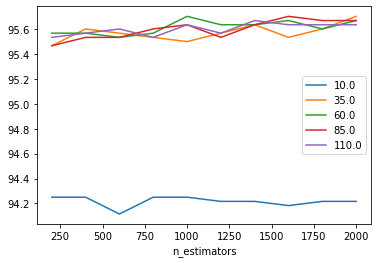

In [350]:
#df.set_index('n_estimators', inplace=True)
df.groupby('max_depth')['mean_test_score'].plot(legend=True)

In [358]:
md = df.groupby('max_depth')

In [367]:
md.get_group(10.0)

,max_depth,n_estimators,mean_test_score
0,10.0,200,94.250711
1,10.0,400,94.250814
2,10.0,600,94.115450
3,10.0,800,94.250780
4,10.0,1000,94.250780
5,10.0,1200,94.216939
6,10.0,1400,94.216939
7,10.0,1600,94.183132
8,10.0,1800,94.216973
9,10.0,2000,94.216973


In [368]:
ne = df.groupby('n_estimators')

In [372]:
th = ne.get_group(200)

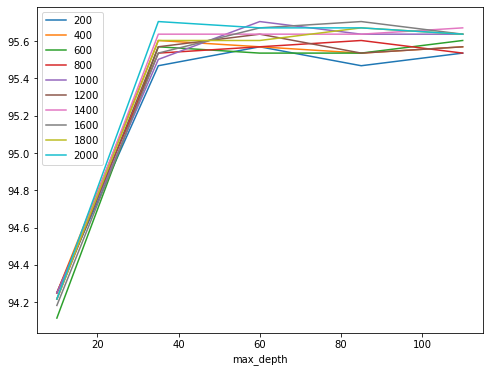

In [379]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(8,6))
ne.plot(kind='line', x = "max_depth", y = "mean_test_score", ax=ax)
ax.legend(labels=ne.groups.keys())

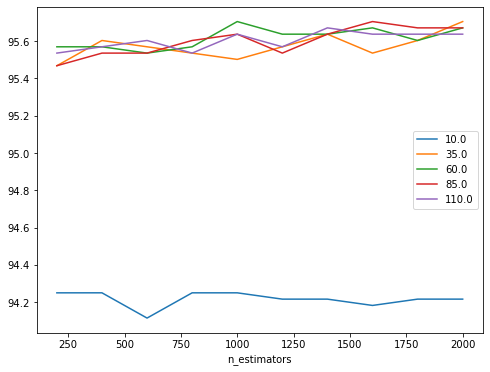

In [380]:
md = df.groupby('max_depth')
fig, ax = plt.subplots(figsize=(8,6))
md.plot(kind='line', x = "n_estimators", y = "mean_test_score", ax=ax)
ax.legend(labels=md.groups.keys())

n_estimators
200     AxesSubplot(0.125,0.125;0.775x0.755)
400     AxesSubplot(0.125,0.125;0.775x0.755)
600     AxesSubplot(0.125,0.125;0.775x0.755)
800     AxesSubplot(0.125,0.125;0.775x0.755)
1000    AxesSubplot(0.125,0.125;0.775x0.755)
1200    AxesSubplot(0.125,0.125;0.775x0.755)
1400    AxesSubplot(0.125,0.125;0.775x0.755)
1600    AxesSubplot(0.125,0.125;0.775x0.755)
1800    AxesSubplot(0.125,0.125;0.775x0.755)
2000    AxesSubplot(0.125,0.125;0.775x0.755)
Name: mean_test_score, dtype: object

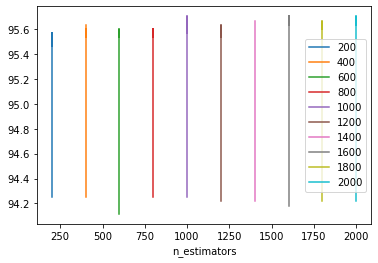

In [351]:
df.groupby('n_estimators')['mean_test_score'].plot(legend=True)

In [348]:
for d in max_depth:
    title = 'Geoserver : accuracy for max_depth={}'.format(d)
    df.plot(x='n_estimators',y='accuracy', title=title)

KeyError: 'n_estimators'